# Уменьшение потребления электроэнергии при производстве стали

**Исходные данные:** 
данные по замерам активной и реактивной мощностей на электродах, объемы и время подчаи сыпучих и проволочных материалов, объемы газа для продувки, данные о температурных замерах

* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).


Во всех файлах столбец key содержит номер партии.

**Цель:**
построить модель регрессии для предсказания температуры стали для уменьшения энергопотребления при ее производстве и добиться показателей метрики MAE менее 6



**Этапы исследования:**

1. Загрузка исходных данных и их общая оценка, построение гистрограмм для каждого столбца с числовыми значениями
2. Исследовательский анализ данных 
3. Обучение и выбор нескольких base-line моделей
4. Обучение и тестирование модели
5. Заключение
6. Отчет


Цель данной работы заключается в создании и обучении модели для предсказания температуры стали на различных этапах обработки. Основная цель — оптимизация производственных расходов на металлургическом комбинате "Так закаляем сталь" путем снижения потребления электроэнергии на этапе обработки стали. Модель должна предсказывать температуру стали с высокой точностью, позволяя операторам производства более эффективно управлять процессом.

Для достижения этой цели необходимо провести анализ и обработку данных из разных источников, таких как данные об электродах, подаче сыпучих и проволочных материалов, продувке газом, измерениях температуры и других параметрах процесса. Затем следует разработать и обучить модель машинного обучения на основе предоставленных данных, чтобы она могла предсказывать температуру стали на разных этапах обработки.

Эффективная модель предсказания температуры позволит операторам металлургического комбината более точно контролировать процесс обработки стали, оптимизировать параметры и ресурсы, а также улучшить качество готовой продукции.

Технологический процесс производства стали на металлургическом комбинате "Так закаляем сталь" состоит из:

1. Подготовка сырья и начальная обработка:

Сырье (чугун, лом стали и другие компоненты) поступает на комбинат и проходит сортировку, очистку от загрязнений.
Отобранное сырье помещается в металлический ковш, вместимостью около 100 тонн.
Облицовка ковша:

Внутренние поверхности ковша облицовываются огнеупорным кирпичом, чтобы обеспечить ему устойчивость к высоким температурам.

2. Плавка стали:

Расплавленное сырье заливается в ковш.
Для нагрева стали до нужной температуры используются графитовые электроды, которые установлены в крышке ковша. Под действием электрического тока электроды нагреваются и передают тепло стали.

3. Десульфурация и легирование:

Из сплава выводится сера для улучшения химического состава стали.
Химический состав стали корректируется добавлением легирующих материалов, которые могут быть сыпучими или проволочными.

4. Измерения и контроль:

Перед введением легирующих добавок измеряется температура стали и производится химический анализ.
Добавление легирующих материалов с последующей продувкой сплава инертным газом.
Проводятся измерения и контроль параметров сплава, такие как температура и химический состав.

5. Цикл повторений:

Цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

6. Доводка металла или разливка:

Расплавленная сталь после обработки может быть отправлена на доводку металла для улучшения его свойств или поступать в машину непрерывной разливки.
В случае непрерывной разливки готовый продукт выходит в виде заготовок-слябов, которые затем могут быть дальше обработаны.


Весь этот процесс строится на точных измерениях температуры, химического состава и других параметров, чтобы обеспечить качество и соответствие стали требуемым характеристикам. Постоянный мониторинг и коррекция параметров позволяют достичь оптимальных результатов в эффективной и качественной обработке стали.



## 1 Загрузка исходных данных

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from math import ceil

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler

RANDOM_STATE = 10823

In [62]:
class ShowData:
    '''

    there are the methods for help to look thought the data
    "download_data" open dataset(download) from collab and from other paths,
    "change_data" replaces name of columns according to PEP8 and convert 
    to lower data type,
    "general_info" provides with the numbers of columns/rows, type of columns 
    and occupied memory,
    "deep_info" provides with statistic info and info for preprocessing step,
    "hist_box" shows histograms and boxplots for each numeric column,
    "cor_matrix" shows correlation matrix for all numeric columns, 
    it uses Pearson coefficient

    '''

    def download_data(self, path):

        import os
        if os.path.exists(path):
            df = pd.read_csv(path)
        elif os.path.exists(path):
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv(path)
        else:
            print("The path doesn't exist")

        return df

    def change_data(self, df):


        df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.lower())
        try:
            for name in df.select_dtypes("number").columns:
                df[name] = pd.to_numeric(df[name], downcast="float"
                                        if (df[name] // 1 == 0).all()
                                        else "integer")
        except:
            pass
        return df

    def general_info(self, df):

        info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
        info_0.loc["columns", ""] = len(df.columns)
        info_0.loc["row", ""] = len(df)
        info_0.loc["memory_usage, MB", ""] = df.memory_usage()\
        .sum() / (1024 ** 2)

        return info_0

    def deep_info(self, df):

        info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
        info_1["null_row"] = (df == 0).sum(axis=0)
        info_1["uniq"] = df.nunique()
        info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
        info_1["dup_row"] = df.duplicated().sum()
        info_1["NaN"] = df.isna().sum()
        info_1["NaN,%"] = df.isna().mean()
        info_1["type"] = df.dtypes
        info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
        info_1.fillna("", inplace=True)
        for col in info_1.loc[:, "mean":]:
            info_1[col] = pd.to_numeric(info_1[col], downcast="float")
        info_1["null_row"] = pd.to_numeric(info_1["null_row"], 
                                           downcast="integer")
        info_1["outliers"] = info_1["max"] > info_1["75%"] \
                             + 1.5 * (info_1["75%"] - info_1["25%"])

        prop = {
            "border": "0.5px solid black",
            "width": "85px",
            "text-align": "center"
        }
        percent = {
            "NaN,%":"{:.3%}",
            "mean":"{:.3}",
            "std":"{:.3}",
            "min":"{:.3}",
            "25%":"{:.3}",
            "50%":"{:.3}",
            "75%":"{:.3}",
            "max":"{:.3}",
        }

        return info_1, info_1.style.format(percent).set_properties(**prop)

    def hist_box(self, df, size=None):

        df_num = df.select_dtypes("number")
        columns_num = len(df_num.columns)
        size = None
        if size is None:
            if columns_num < 5:
                size = (14, 4)
            else:
                size = (15, 10)
        fig = plt.figure(figsize=size)
        sfigs = fig.subfigures(ceil(columns_num/4), 4)
        for i, axes in enumerate(sfigs.flat):
            try:
                axes.suptitle(df_num.columns[i])
                if len(df_num.iloc[:,i]) > 0:
                    ax_1= axes.subplots(2, 1, sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)
                                            }
                                        )

                    g1 = sns.boxplot(data=df_num, x=df_num.columns[i], orient="h",
                    ax=ax_1[0])
                    g1.set(xlabel=None)
                    g2 = sns.histplot(data=df_num, x=df_num.columns[i], kde=True,
                                    ax=ax_1[1])
                    g2.set(xlabel=None)

                    
            except:
                break
        plt.show()

    def cor_matrix(self, df):

        length = len(df.columns)
        plt.figure(figsize=(length/1.5, length/1.5))
        sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.3,
            cmap="coolwarm", square=True)
        plt.show()

In [63]:
# create a variable for class
sd = ShowData()
# download data
data_arc = sd.download_data("data_arc.csv")
data_bulk_time = sd.download_data("data_bulk_time.csv")
data_bulk = sd.download_data("data_bulk.csv")
data_gas = sd.download_data("data_gas.csv")
data_temp = sd.download_data("data_temp.csv")
data_wire_time = sd.download_data("data_wire_time.csv")
data_wire = sd.download_data("data_wire.csv")

#create a dictionary for data sets for displaying
data_list = {
    "data_arc": data_arc, 
    "data_bulk_time": data_bulk_time, 
    "data_bulk": data_bulk, 
    "data_gas": data_gas, 
    "data_temp": data_temp, 
    "data_wire_time": data_wire_time, 
    "data_wire": data_wire
    }

In [64]:
# show first 3 rows
for name, data in data_list.items():
    print(f'It\'s dataframe named \033[1m{name}\033[0m')
    display(data.head(3))
    print()

It's dataframe named data_arc


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460


It's dataframe named data_bulk_time


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16


It's dataframe named data_bulk


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0


It's dataframe named data_gas


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793


It's dataframe named data_temp


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0


It's dataframe named data_wire_time


key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8  \
0    1  2019-05-03 11:06:19    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

  Wire 9  
0    NaN  
1    NaN  
2    NaN


It's dataframe named data_wire


key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN

In [65]:
# invert the data columns to snake case
data_arc = sd.change_data(data_arc)
data_bulk_time = sd.change_data(data_bulk_time)
data_bulk = sd.change_data(data_bulk)
data_gas = sd.change_data(data_gas)
df5data_temp = sd.change_data(data_temp)
data_wire_time = sd.change_data(data_wire_time)
data_wire = sd.change_data(data_wire)

In [66]:
# look through the general info about data
for name, info in data_list.items():
    print(f'It\'s dataframe named \033[1m{name}\033[0m')
    display(sd.general_info(info))
    print()

It's dataframe named data_arc


object                2.000000
float64               2.000000
int16                 1.000000
columns               5.000000
row               14876.000000
memory_usage, MB      0.482475


It's dataframe named data_bulk_time


object              15.000000
int16                1.000000
columns             16.000000
row               3129.000000
memory_usage, MB     0.364176


It's dataframe named data_bulk


float64             15.000000
int16                1.000000
columns             16.000000
row               3129.000000
memory_usage, MB     0.364176


It's dataframe named data_gas


int16                1.000000
float64              1.000000
columns              2.000000
row               3239.000000
memory_usage, MB     0.031012


It's dataframe named data_temp


int16                 1.000000
object                1.000000
float64               1.000000
columns               3.000000
row               18092.000000
memory_usage, MB      0.310692


It's dataframe named data_wire_time


object               9.000000
int16                1.000000
columns             10.000000
row               3081.000000
memory_usage, MB     0.217554


It's dataframe named data_wire


float64              9.000000
int16                1.000000
columns             10.000000
row               3081.000000
memory_usage, MB     0.217554

In [67]:
# look through the general info about data
for name, info in data_list.items():
    print(f'It\'s dataframe named \033[1m{name}\033[0m')
    display(sd.deep_info(info)[1])
    print()

It's dataframe named data_arc



It's dataframe named data_bulk_time



It's dataframe named data_bulk



It's dataframe named data_gas



It's dataframe named data_temp



It's dataframe named data_wire_time



It's dataframe named data_wire


In [68]:
data_temp["температура"].min()

1191.0

In [69]:
data_temp["температура"].max()

1705.0

Некоторые столбцы в данных необходимо конвертировать в тип, соответствующий дате. Довольно много пропусков в данных о добавлении сыпучих/проволочных материалов, что вполне закономерно, потому как определенные материалы могут добавляться только на этапе легирования для определенной партии. Данные о температурных этапах так же содержат пропуски.

Нулевые значения и полные дубликаты строк отсутствуют в данных. Есть один дубликат значения даты начала нагрева в данных о мощности.

Значение активной мощности лежит в диапазоне от 223 Вт до 1460 Вт, со средним значением 663 Вт. Значение реактивной мощности - от -715000 Вт до 1270 Вт со средним значением 439 Вт. Используемые объемы газа для продувки от 0.0084 $м^3$ до 78 $м^3$ со средним значением 11 $м^3$. Температуры нагрева - от 1191&deg;С до 1705&deg;С. Нижняя граница довольно низкая с учетом того, что температура плавления углеродистой стали начинается от 1370&deg;С. Рекомендуется уточнить технологический процесс, потому как данная температура нехарактерна для большинства процессов обработки стали. 

Используемый в этом случае сплав, в соответствии с диаграммой железо-углерод, близок по структуре к ледебуритным(карбидным) сталям типа быстрорежущие стали Р9, Р18, Р6М5 ГОСТ 19265-73 или стали для инструмента холодной штамповки Х12, Х12ВМ, Х12Ф1 ГОСТ 5950-2000. 

In [70]:
data_arc.rename(columns={
    "начало_нагрева_дугой":"arc_heating_start",
    "конец_нагрева_дугой":"arc_heating_end",
    "активная_мощность":"active_power",
    "реактивная_мощность":"reactive_power"
    }, inplace=True)
data_gas.rename(columns={
    "газ_1":"gas"
    }, inplace=True)
data_temp.rename(columns={
    "время_замера":"temp_time",
    "температура":"temperature"
    }, inplace=True)

It's dataframe named data_arc


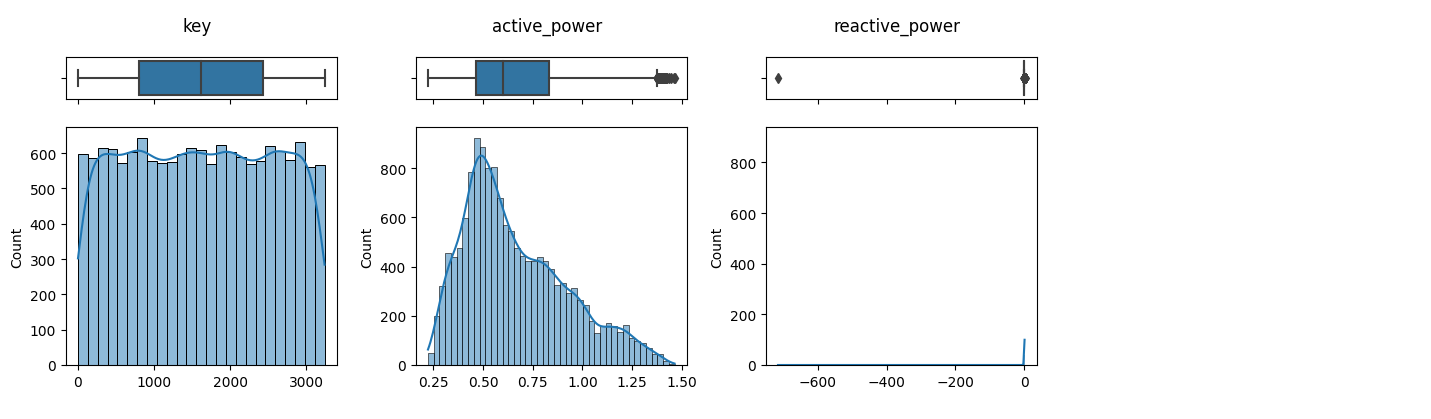

It's dataframe named data_bulk_time


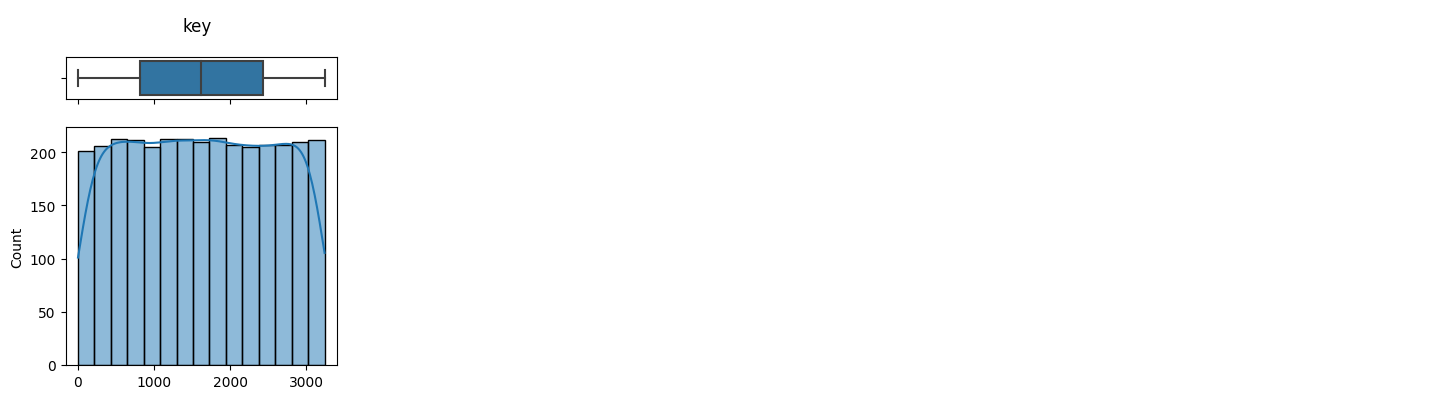

It's dataframe named data_bulk


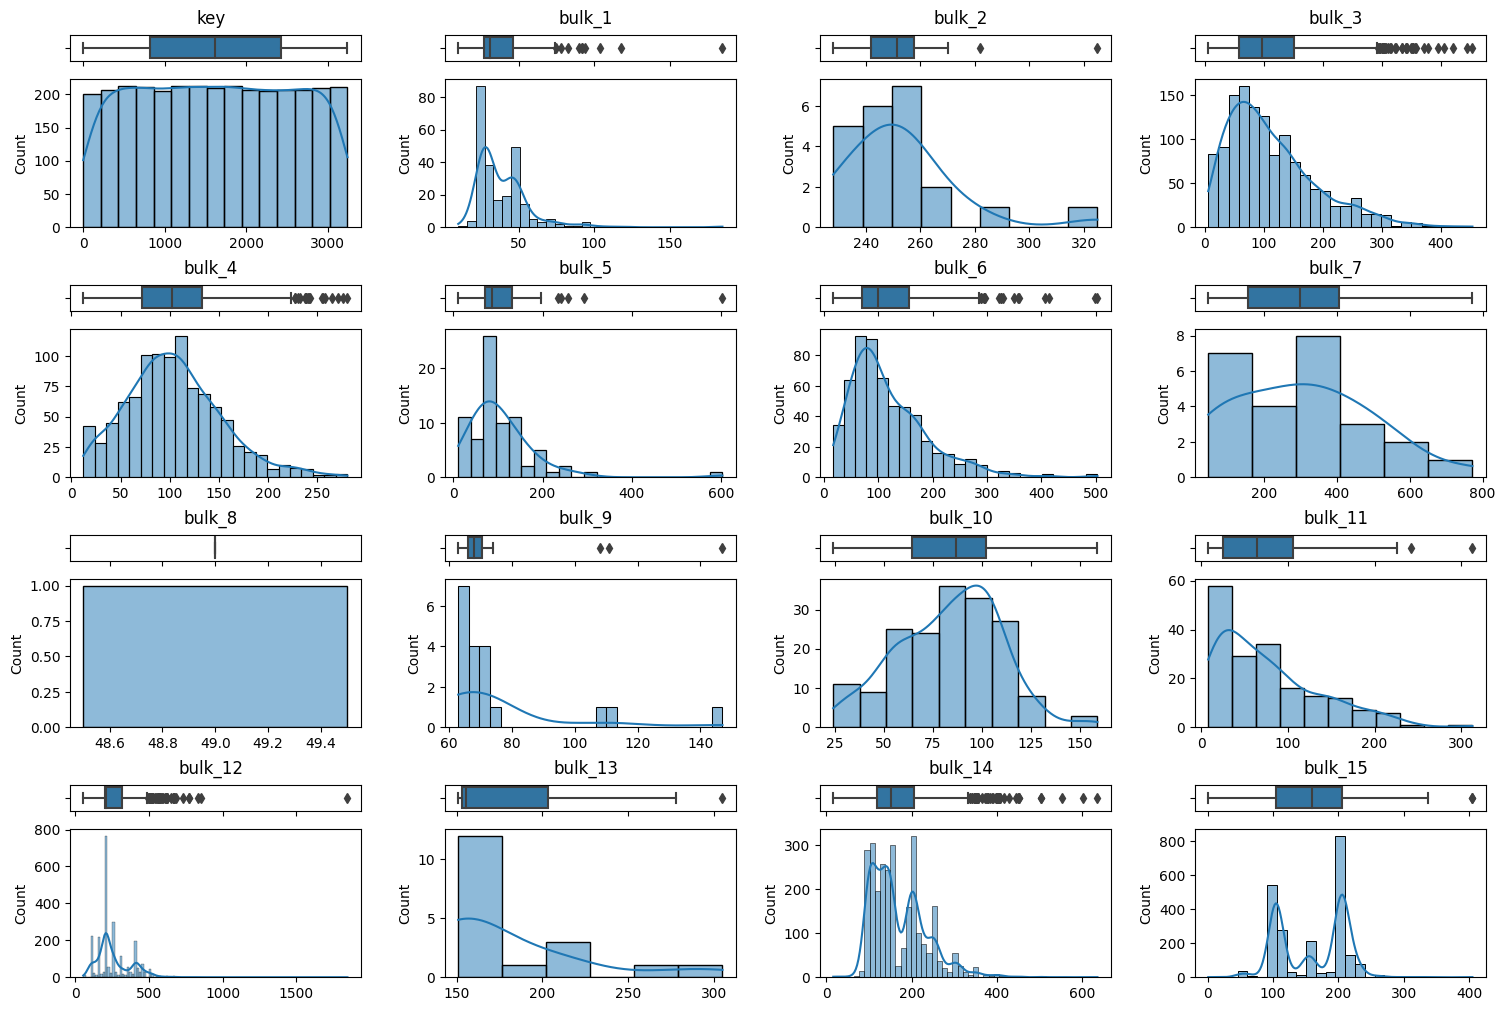

It's dataframe named data_gas


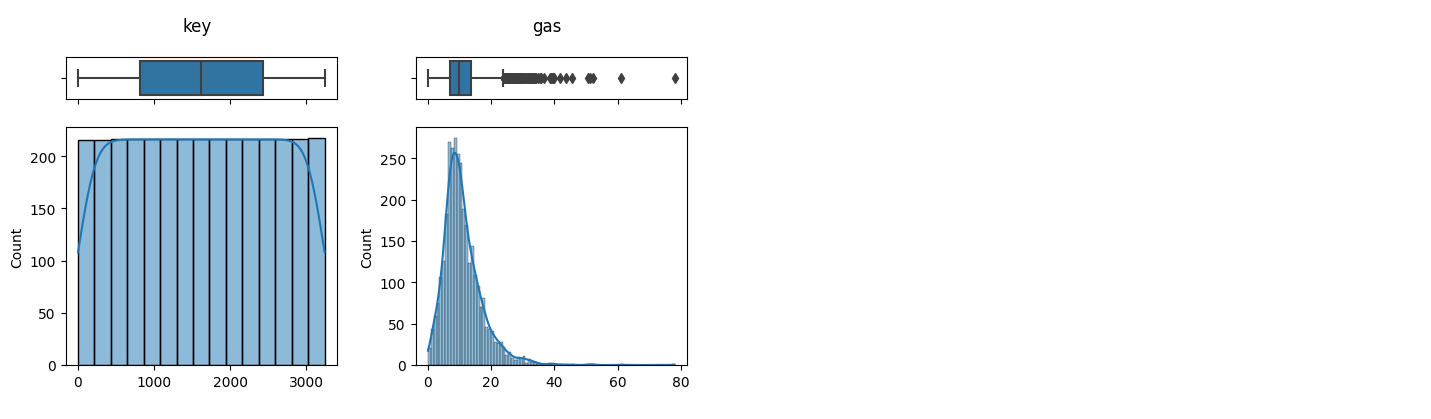

It's dataframe named data_temp


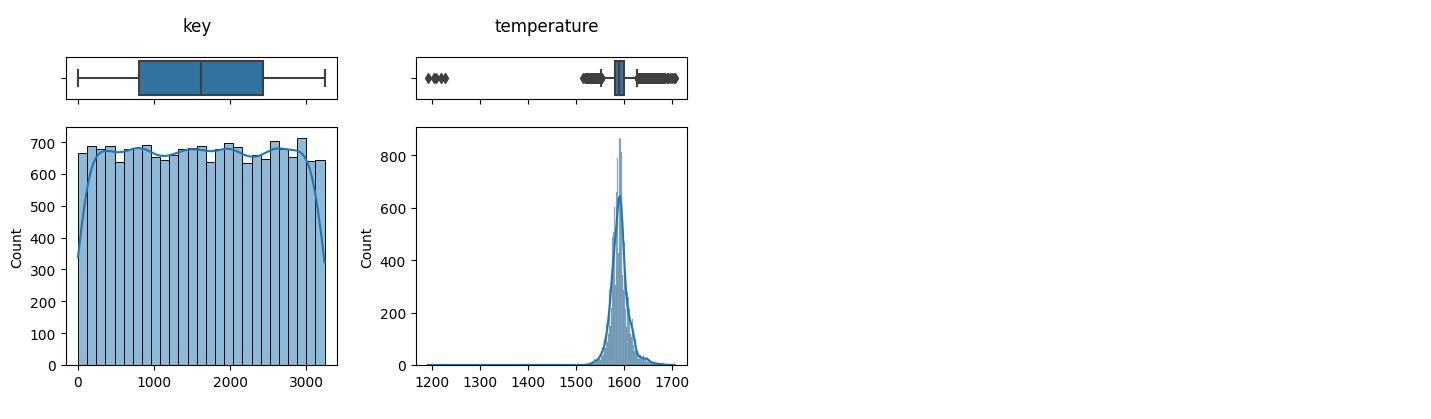

It's dataframe named data_wire_time


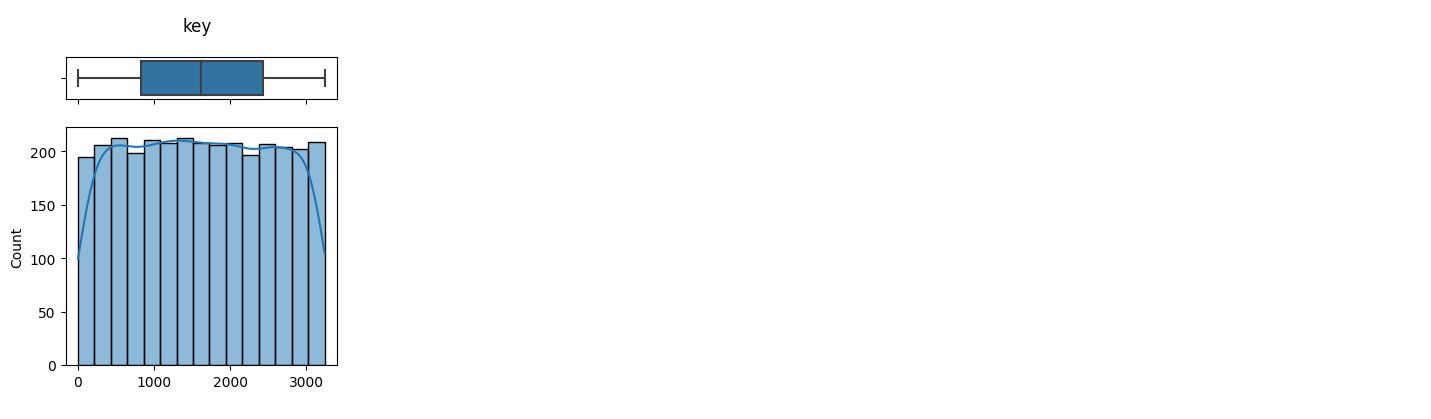

It's dataframe named data_wire


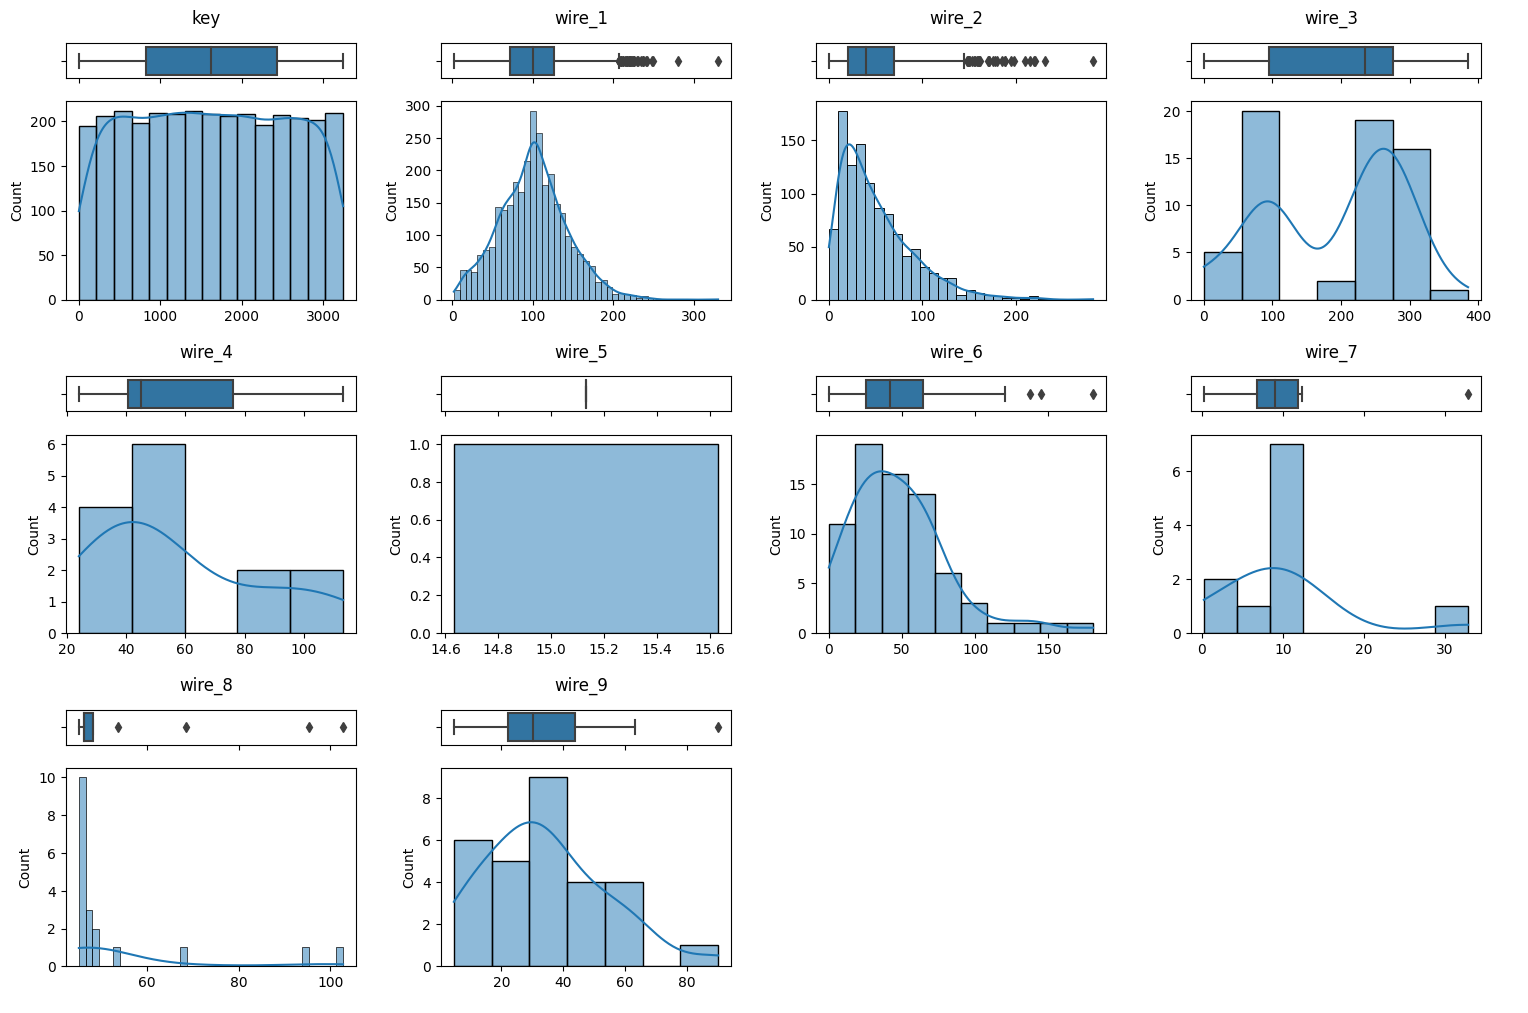

In [71]:
# look through the distribution of data
for name, info in data_list.items():
    print(f'It\'s dataframe named \033[1m{name}\033[0m')
    sd.hist_box(info)

На графиках распределения реактивной мощности видны аномальные значения, которые могут говорить о скачках напражения, неисправности оборудования, необходимости замены конденсаторов в сети для компенсации реактивной мощности и т.д. Для принятия решения необходимо провести дополнительный исследовательский анализ данных во временном разрезе.

Распределение объема сыпучих материалов на графике подтверждает теорию о том, что некоторые типы материалов представлены в ограниченном количестве, недостаточном для дальнейшей работы.

Объем подачи газа, со средним 11 $м^3$, имеет аномально высокие максимальные значения. Температурные показатели - аномально низкие значения.

Некоторые проволочные материалы так же подлежат удалению ввиду малого количества наблюдений.

### Вывод
Проведенный анализ данных выявил несколько ключевых наблюдений и аномалий, которые могут иметь технологическую значимость.

1. Температурные аномалии. 

Обнаружены низкие значения температур плавления стали, такие как 1191°C, что не характерно для типичных процессов обработки стали. Предполагается, что данная температура может соответствовать сталям с особыми характеристиками, таким как ледебуритные (карбидные) стали типа быстрорежущие стали или стали для инструментов холодной штамповки.

2. Аномальные значения мощности. 

Обнаружены выбросы в данных о реактивной мощности, что может указывать на возможные скачки напряжения, неисправности оборудования или необходимость компенсации реактивной мощности. Рекомендуется дополнительный анализ данных во временном разрезе для выявления причин этих аномалий.

3. Оптимизация подачи материалов. 

Наблюдается недостаточное количество данных о подаче сыпучих и проволочных материалов, что может повлиять на качество и производительность процесса обработки стали. Рекомендуется оптимизировать подачу материалов или искать альтернативные решения для обеспечения устойчивости производства.

4. Объем газа для продувки. 

Выявлены аномально высокие максимальные значения объема газа для продувки стали, что может быть связано с изменениями в производственных процессах или оборудовании. Рекомендуется проанализировать источники этих аномалий и оптимизировать объемы газа для обеспечения эффективной продувки.



Исходя из данных наблюдений, рекомендуется провести дополнительные исследования и анализ данных. Анализ аномалий в мощности и температуре поможет выявить и устранить возможные проблемы с оборудованием или электрическими системами, что способствует повышению эффективности и надежности процесса производства стали.

## 2 Анализ данных

В рамках предварительной подготовки данных для анализа произведем следующие шаги:

1. Изменим тип данных для столбцов с датами

2. Объеденим данные об объемах сыпучих/проволочных материалов с временем их добавления

In [72]:
data_arc["arc_heating_start"] = pd.to_datetime(data_arc["arc_heating_start"])
data_arc["arc_heating_end"] = pd.to_datetime(data_arc["arc_heating_end"])

for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

data_temp["temp_time"] = pd.to_datetime(data_temp["temp_time"])

for col in data_wire_time.columns[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [73]:
data_bulk_time.dtypes

key                 int16
bulk_1     datetime64[ns]
bulk_2     datetime64[ns]
bulk_3     datetime64[ns]
bulk_4     datetime64[ns]
bulk_5     datetime64[ns]
bulk_6     datetime64[ns]
bulk_7     datetime64[ns]
bulk_8     datetime64[ns]
bulk_9     datetime64[ns]
bulk_10    datetime64[ns]
bulk_11    datetime64[ns]
bulk_12    datetime64[ns]
bulk_13    datetime64[ns]
bulk_14    datetime64[ns]
bulk_15    datetime64[ns]
dtype: object

In [74]:
bulk_full = data_bulk.merge(data_bulk_time, 
                            on="key", 
                            suffixes=["_volume","_time"])

wire_full = data_wire.merge(data_wire_time, 
                            on="key", 
                            suffixes=["_volume","_time"])

### Мощность 

Рассмотрим так же фактор мощности, как соотношение активной и плоной мощностей, для оценки энергоэффективности системы

In [75]:
data_power = data_arc.copy()
data_power["factor_power"] = data_power.active_power\
      / abs((data_power.active_power ** 2/
              + data_power.reactive_power ** 2) ** .5)

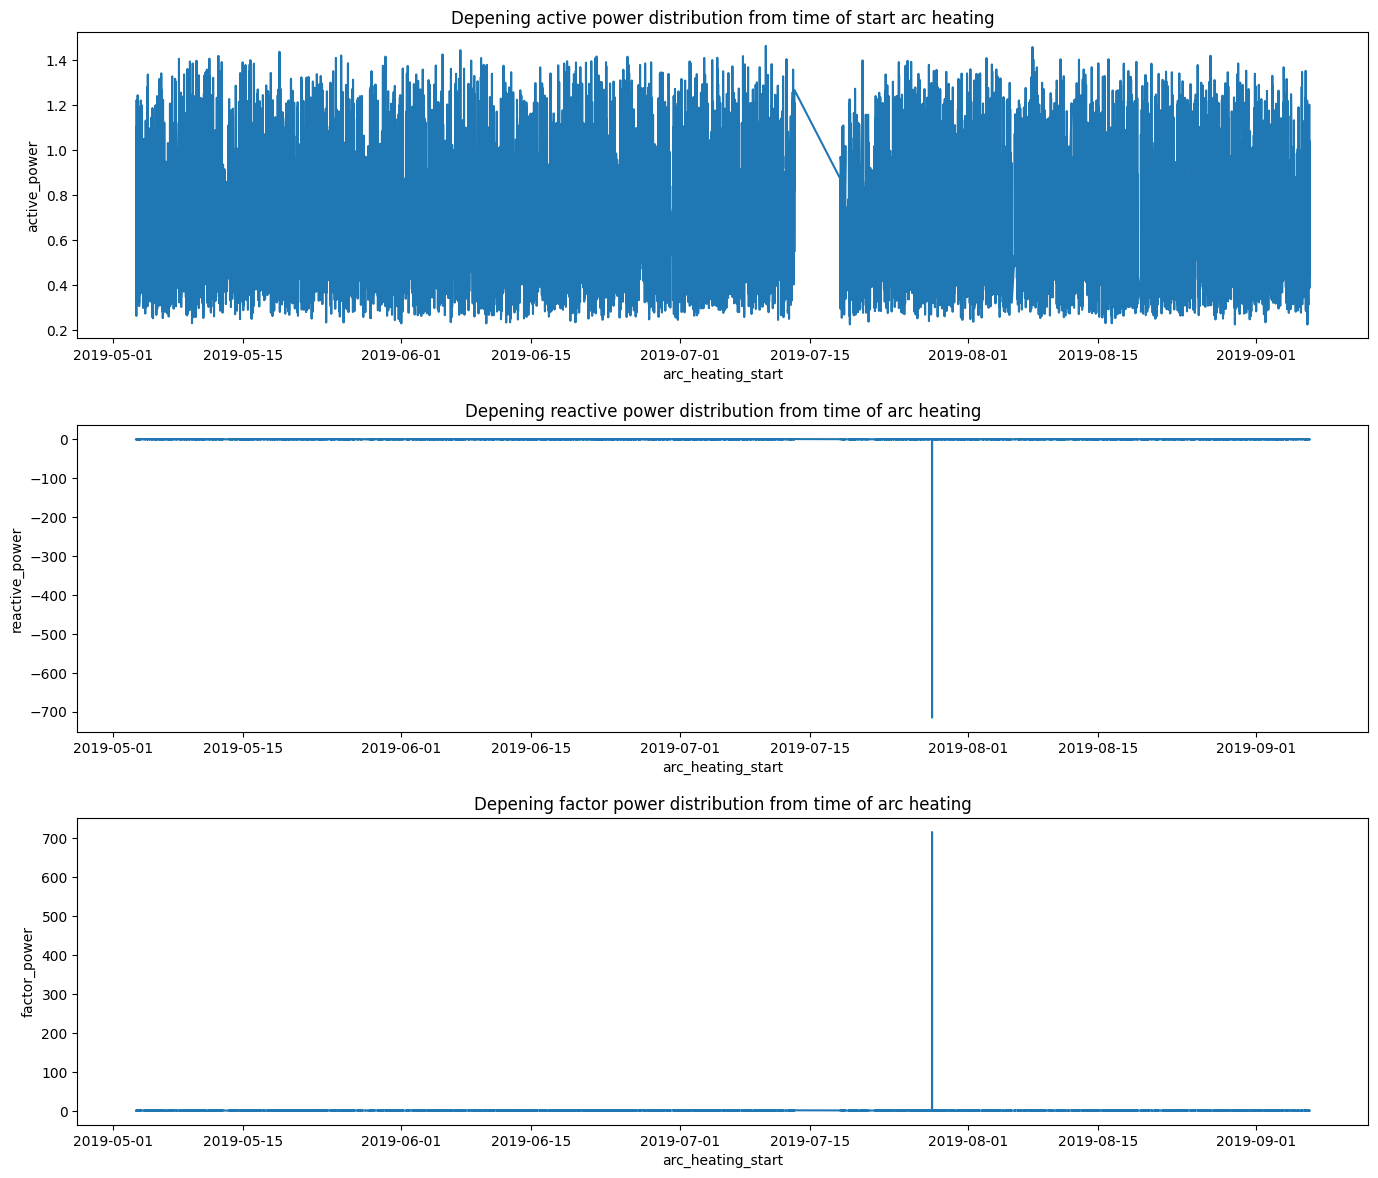

In [76]:
_, axis = plt.subplots(3, 1, figsize=(14, 12))
axis[0].set_title(
    "Depening active power distribution from time of start arc heating"
    )
sns.lineplot(data=data_power, y="active_power", x="arc_heating_start", 
             ax=axis[0])
axis[1].set_title("Depening reactive power distribution from time of arc heating")
sns.lineplot(data=data_power, y="reactive_power", x="arc_heating_start", 
             ax=axis[1])
axis[2].set_title("Depening factor power distribution from time of arc heating")
sns.lineplot(data=data_power, y="factor_power", x="arc_heating_start", 
             ax=axis[2])
plt.tight_layout(pad=1.5)
plt.show()

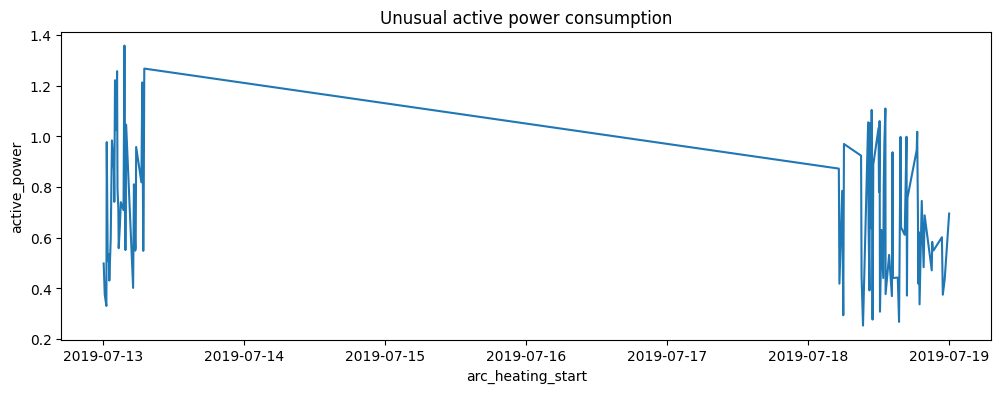

In [77]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=data_power[
    (data_power.arc_heating_start > '2019-07-13')
    &(data_power.arc_heating_start < '2019-07-19')], 
    y="active_power", x="arc_heating_start")
plt.title("Unusual active power consumption")
plt.show()

In [78]:
data_power[
    (data_power.arc_heating_start > '2019-07-14')
    &(data_power.arc_heating_start < '2019-07-18')
    ]

Empty DataFrame
Columns: [key, arc_heating_start, arc_heating_end, active_power, reactive_power, factor_power]
Index: []

Простой в рабочие дни июля с 14-го(воскресенье) по 18-ое(четверг). Предположительно, плановое техническое обслуживание.

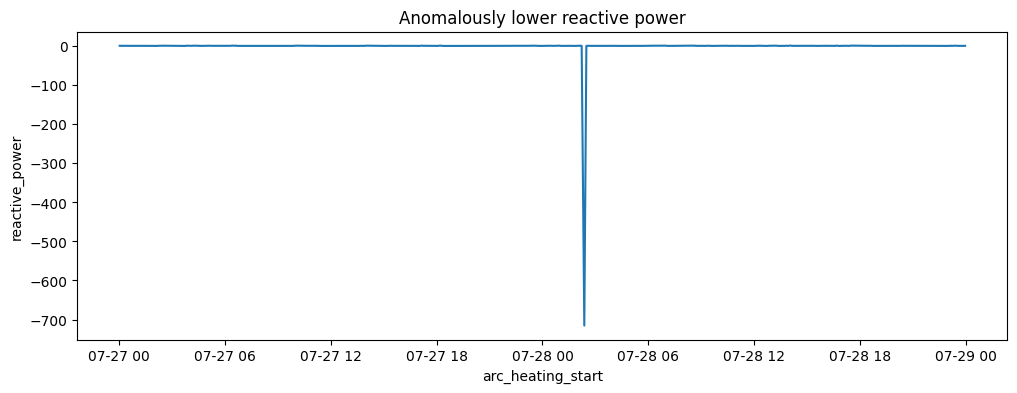

In [79]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=data_power[
    (data_power.arc_heating_start > '2019-07-27')
    &(data_power.arc_heating_start < '2019-07-29')], 
    y="reactive_power", x="arc_heating_start")
plt.title("Anomalously lower reactive power")
plt.show()

In [80]:
data_power[
    (data_power.arc_heating_start > '2019-07-28')
    &(data_power.arc_heating_start < '2019-07-29')
    &(data_power.reactive_power < 0)]

key   arc_heating_start     arc_heating_end  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  factor_power  
9780     -715.479924    715.479924

In [81]:
display(bulk_full[bulk_full.key == 2116].dropna(axis=1))
display(wire_full[(wire_full.key == 2116)].dropna(axis=1))
display(data_gas[data_gas.key == 2116])
display(data_temp[data_temp.key == 2116])

key  bulk_6_volume  bulk_14_volume         bulk_6_time  \
2044  2116          137.0           198.0 2019-07-28 02:30:28   

            bulk_14_time  
2044 2019-07-28 02:24:14

key  wire_1_volume         wire_1_time
2018  2116      75.216965 2019-07-28 02:15:40

key        gas
2113  2116  11.582547

key           temp_time  temperature
11877  2116 2019-07-28 02:07:02       1579.0
11878  2116 2019-07-28 02:13:00       1574.0
11879  2116 2019-07-28 02:21:58       1578.0
11880  2116 2019-07-28 02:29:01       1575.0
11881  2116 2019-07-28 02:35:36       1578.0

Аномально низкое реактивное значение, при прочих стабильных показателя(объемы газа, температура и т.п.), может указывать на увеличение емкостных нагрузок в сети, перегрузку конденсаторов или проблемы с измерением. Важно провести дополнительные работы для профилактики возникновения аварий в электросети производства. Данные работы могут включать в себя: проверку и настройку компенсационного оборудования, балансировку нагрузки, проверка измерительных приборов и датчиков.

In [82]:
data_power = data_power[data_power.key != 2116]

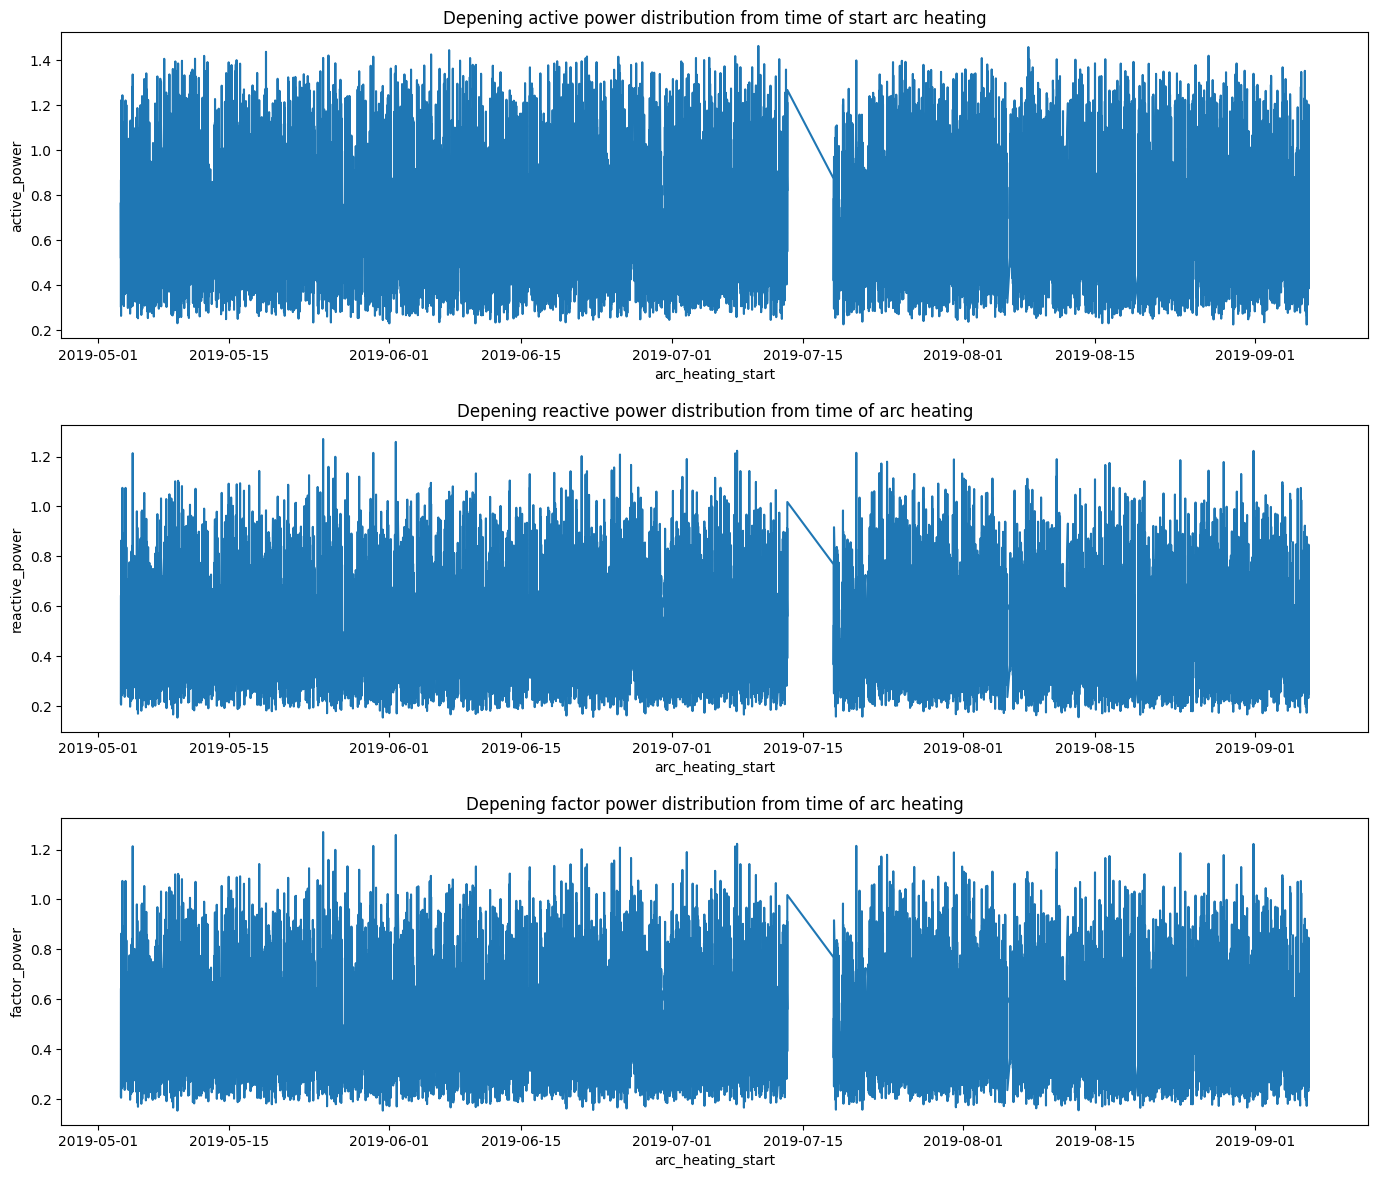

In [83]:
_, axis = plt.subplots(3, 1, figsize=(14, 12))
axis[0].set_title(
    "Depening active power distribution from time of start arc heating"
    )
sns.lineplot(data=data_power, y="active_power", x="arc_heating_start", 
             ax=axis[0])
axis[1].set_title("Depening reactive power distribution from time of arc heating")
sns.lineplot(data=data_power, y="reactive_power", x="arc_heating_start", 
             ax=axis[1])
axis[2].set_title("Depening factor power distribution from time of arc heating")
sns.lineplot(data=data_power, y="factor_power", x="arc_heating_start", 
             ax=axis[2])
plt.tight_layout(pad=1.5)
plt.show()

После удаления аномального значения реактивной мощности мы можем оценить график фактора мощности. Общая тенденция показывает, что система достаточно энергоэффективна, так как среднее значение фактора мощности стабильно держится на уровне около 0.8. На графике нет заметных падений или резких изменений по мощности.

Также мы можем рассмотреть средние значения мощности по каждой партии. 

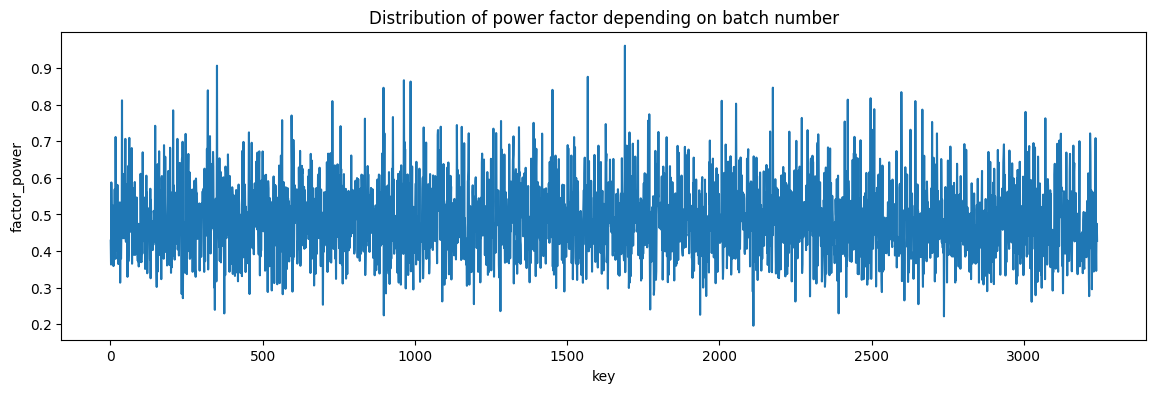

In [84]:
avg_power = data_power.groupby("key")["factor_power"].mean()
plt.figure(figsize=(14, 4))
sns.lineplot(data=avg_power)
plt.title("Distribution of power factor depending on batch number")
plt.show()

In [85]:
avg_power[avg_power < 0.75]

key
1       0.428564
2       0.363339
3       0.587491
4       0.514248
5       0.421998
          ...   
3237    0.405083
3238    0.346034
3239    0.442693
3240    0.474710
3241    0.428002
Name: factor_power, Length: 3180, dtype: float64

Сравнив график распределения фактора мощности с временным графиком распределения активной мощности, мы замечаем более широкий разброс значений фактора мощности. В частности, наблюдаются выбросы с фактором мощности менее 0.75, что указывает на потери энергии в реактивной мощности для определенных партий стали, таких как партии с номерами 1766, 1956 и 2245.

Эти значения указывают на неэффективное использование электроэнергии в электрической системе на указанных этапах производства стали. Низкий фактор мощности означает, что большая часть энергии, поставляемой в систему, тратится на создание магнитного поля или накапливается в индуктивных элементах, а не используется для полезной работы, такой как плавка или нагрев стали.

### Температура

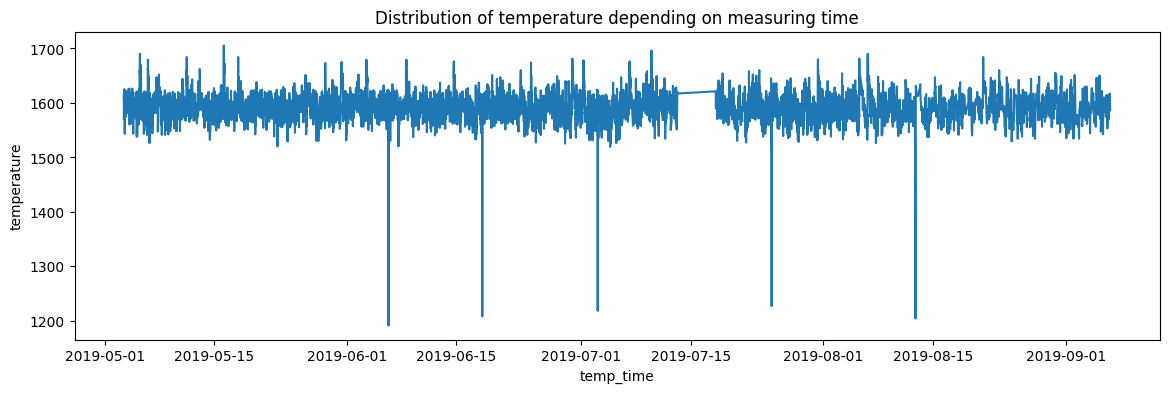

In [86]:
plt.figure(figsize=(14, 4))
sns.lineplot(data=data_temp, y="temperature", x="temp_time")
plt.title("Distribution of temperature depending on measuring time")
plt.show()

Анализ данных показал, что некоторые значения температуры, полученные в процессе производства стали, находятся за пределами ожидаемого диапазона. Эти температуры не соответствуют типичным значениям для процесса плавки стали и могут указывать на возможные нарушения в технологическом процессе.

Конкретно, обнаружены температуры, которые находятся ниже температуры жидкой фазы стали или соответствуют карбидным сплавам, что является нехарактерным для стандартного производственного процесса. В таких случаях, эти данные подлежат удалению из анализа, чтобы обеспечить корректность и достоверность результатов.

In [87]:
data_temp[data_temp.temperature < 1500]

key           temp_time  temperature
4883    867 2019-06-06 08:03:39       1191.0
6784   1214 2019-06-18 08:01:03       1208.0
9050   1619 2019-07-03 02:34:41       1218.0
11495  2052 2019-07-25 08:49:15       1227.0
14283  2561 2019-08-12 18:49:29       1204.0

In [88]:
data_temp = data_temp[
    ~data_temp.key.isin(data_temp[data_temp.temperature < 1500].key)
    ]

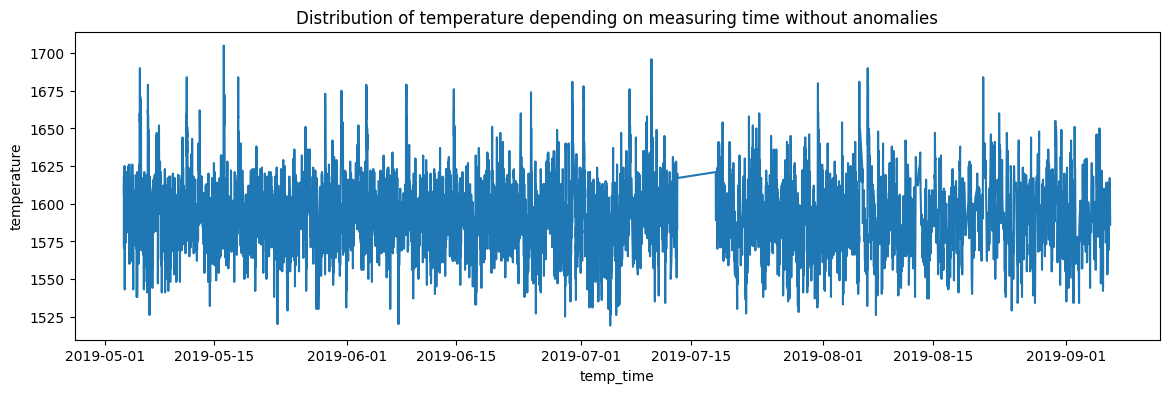

In [89]:
plt.figure(figsize=(14, 4))
sns.lineplot(data=data_temp, y="temperature", x="temp_time")
plt.title("Distribution of temperature depending on measuring time without anomalies")
plt.show()

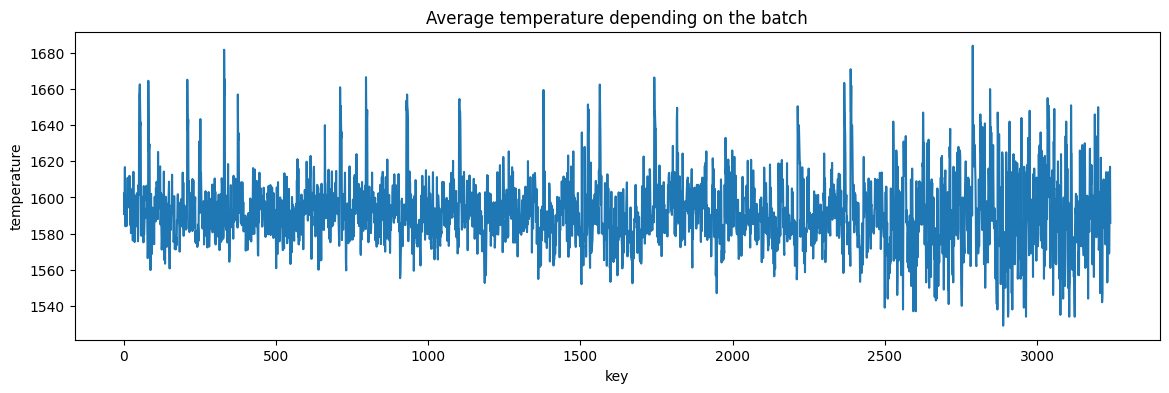

In [90]:
plt.figure(figsize=(14, 4))
sns.lineplot(data=data_temp.groupby('key')['temperature'].mean())
plt.title("Average temperature depending on the batch")
plt.show()

In [91]:
data_temp[data_temp.key > 2500]

key           temp_time  temperature
13931  2501 2019-08-10 14:41:14       1587.0
13932  2501 2019-08-10 14:49:15          NaN
13933  2501 2019-08-10 15:02:56          NaN
13934  2501 2019-08-10 15:07:47          NaN
13935  2501 2019-08-10 15:16:53          NaN
...     ...                 ...          ...
18087  3241 2019-09-06 16:55:01          NaN
18088  3241 2019-09-06 17:06:38          NaN
18089  3241 2019-09-06 17:21:48          NaN
18090  3241 2019-09-06 17:24:44          NaN
18091  3241 2019-09-06 17:30:05          NaN

[4155 rows x 3 columns]

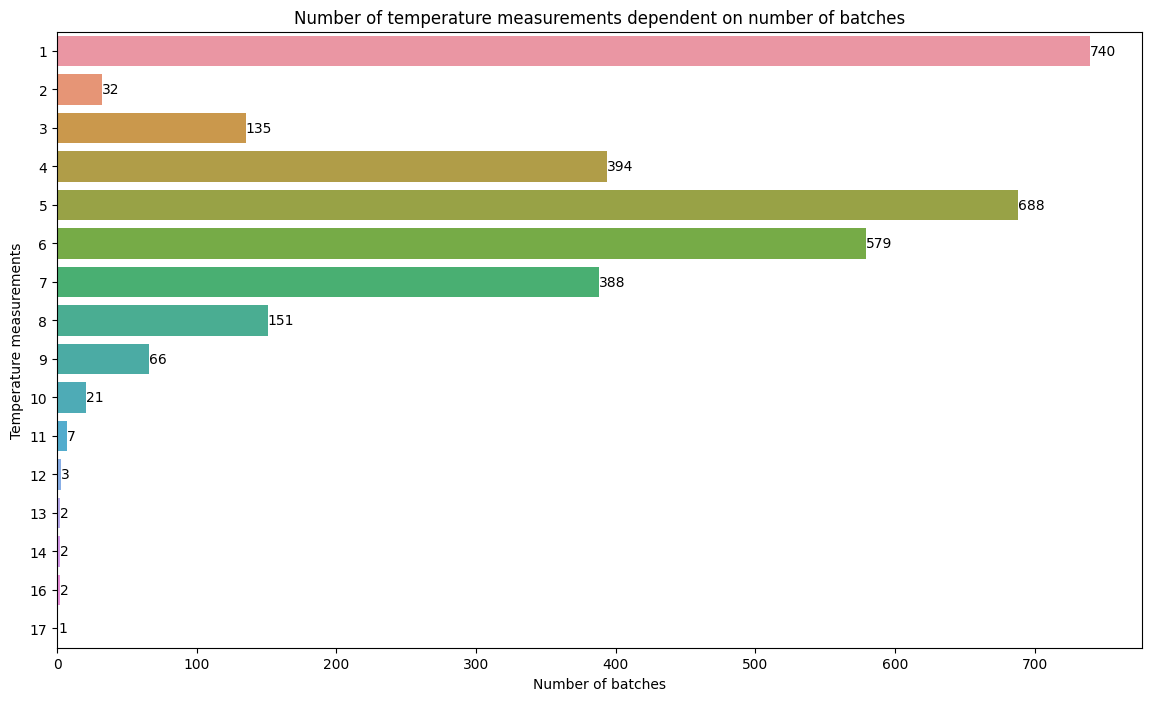

In [92]:
temp_num = data_temp.groupby("key").temperature.count()
temp_iterations = temp_num.reset_index().groupby("temperature").count()
plt.figure(figsize=(14, 8))
ax = sns.barplot(temp_iterations, 
            y=temp_iterations.index,
            x="key", orient="h")
ax.bar_label(ax.containers[0])
plt.title("Number of temperature measurements dependent on number of batches")
plt.xlabel("Number of batches")
plt.ylabel("Temperature measurements")
plt.show()

In [93]:
data_temp = data_temp[
    ~data_temp.key.isin(temp_num[temp_num < 2].index)
    ]

Анализ графика температуры в зависимости от партии указывает на нестабильность процесса нагрева стали от партии к партии. Мы наблюдаем значительный разброс температур в пределах канала от 1570&deg;C до 1630&deg;C, с резкими периодическими всплесками до 1650&deg;C и более высоких значений. Это указывает на неконсистентность и непостоянство параметров нагрева в процессе производства.

Особенно важно отметить, что для партий после 2500-й наблюдается более широкий диапазон разброса температур, колеблющийся от 1540&deg;C до 1640&deg; из-за множества пропущенных значений. Это может свидетельствовать о сбое в измерительном оборудовании.

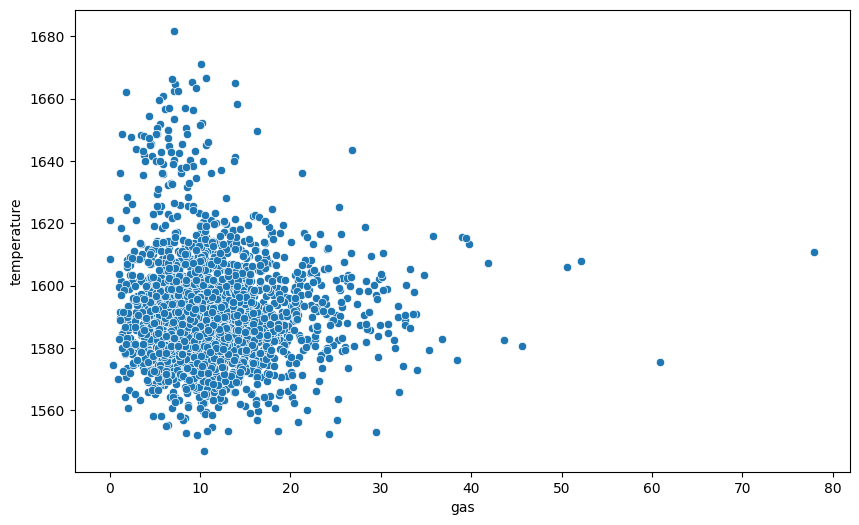

In [94]:
plt.figure(figsize=(10, 6))
sns.scatterplot(pd.merge(data_gas, 
                               data_temp.groupby('key')['temperature'].mean(), 
                               on='key'), x="gas", y="temperature")
plt.show()

In [95]:
data_gas[data_gas.gas > 50]

key        gas
116    117  50.581035
277    280  60.935689
319    322  77.995040
2107  2110  52.142373
2567  2570  51.380229

Замечен высокий перерасход газа для некоторых партий стали. Обычно, в рамках основного диапазона температур (1560 - 1620&deg;C), объемы газа для продувки колеблются в пределах от 5 до 20 $м^3$. Однако, у определенных партий, таких как 117, 280, 322, 2110 и 2570, при тех же рабочих температурах, использовались объемы более 50 $м^3$.

Это явление может быть обусловлено несколькими факторами: неоднородность сырья, технологические отклонения, неисправность оборудования.

### Сыпучие и проволочные материалы

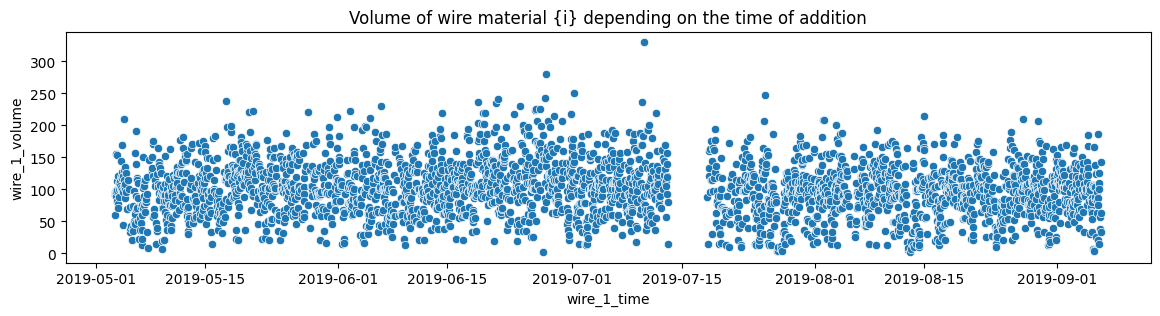

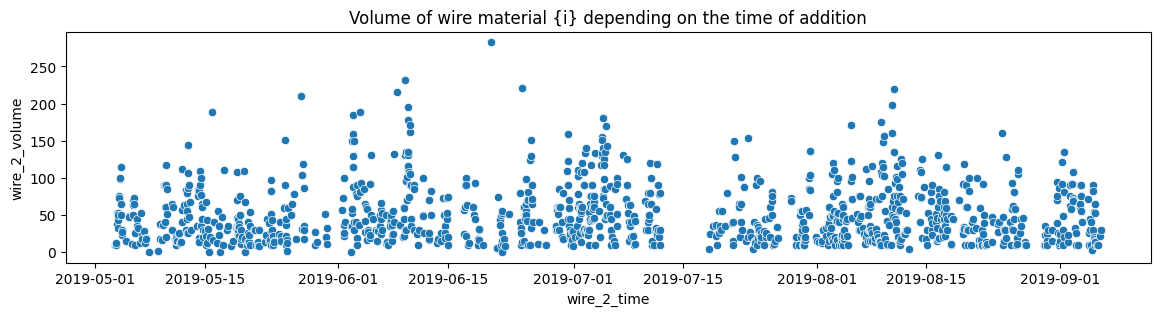

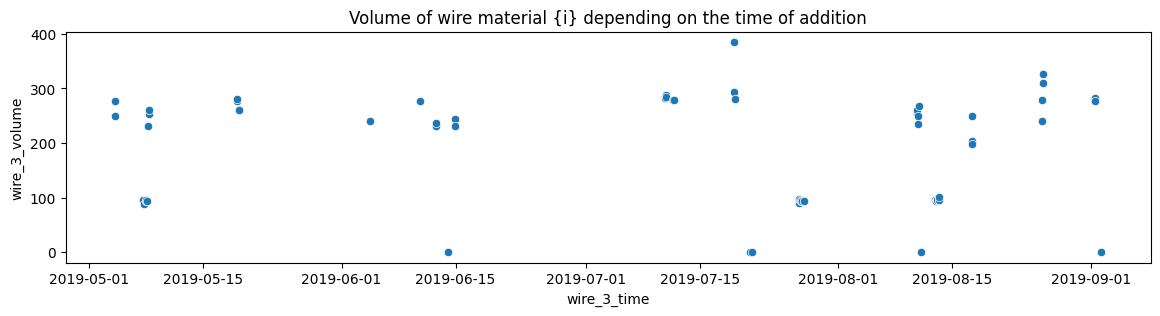

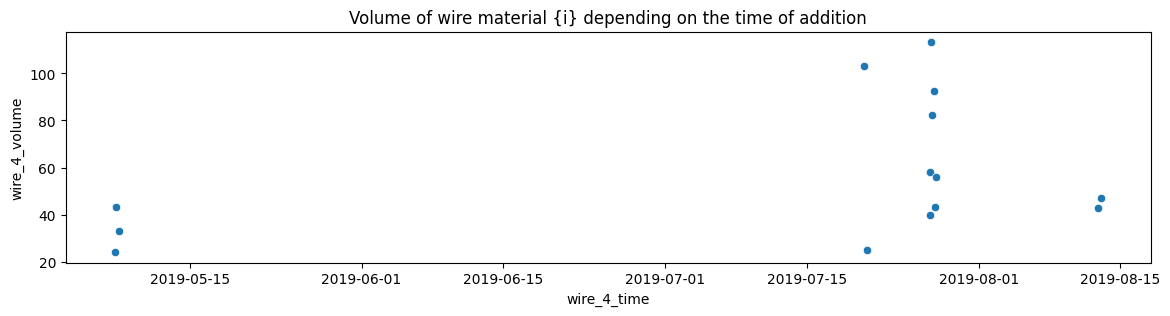

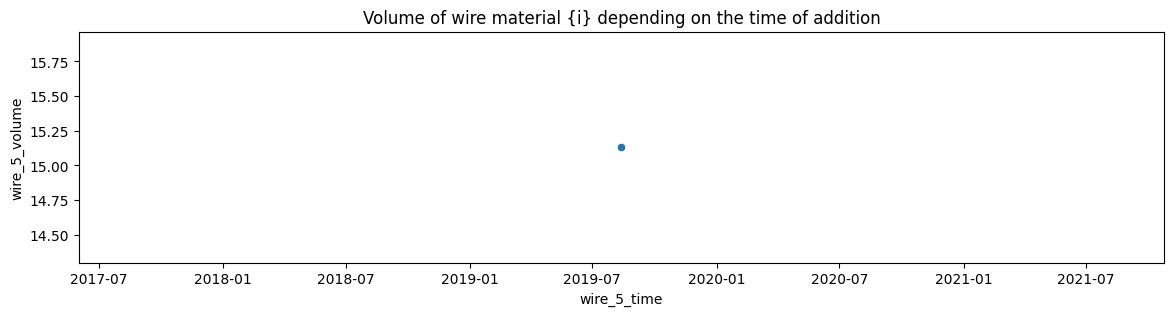

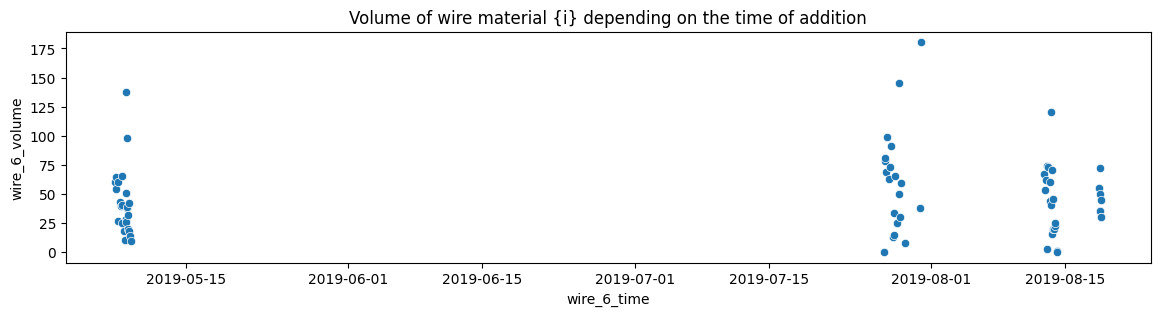

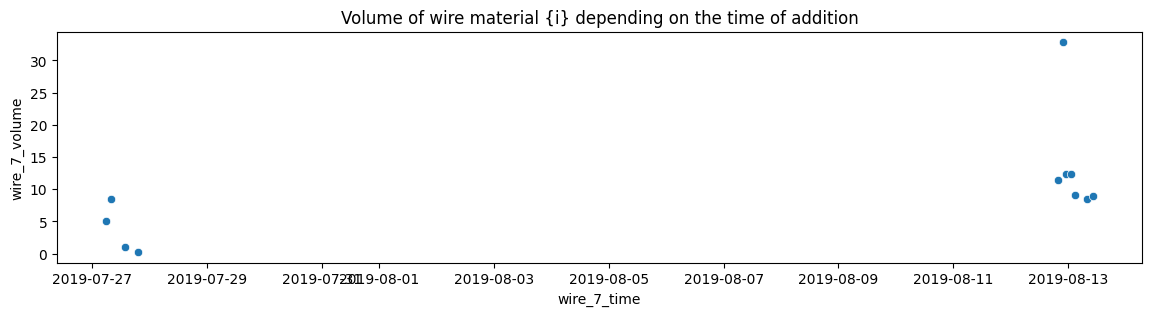

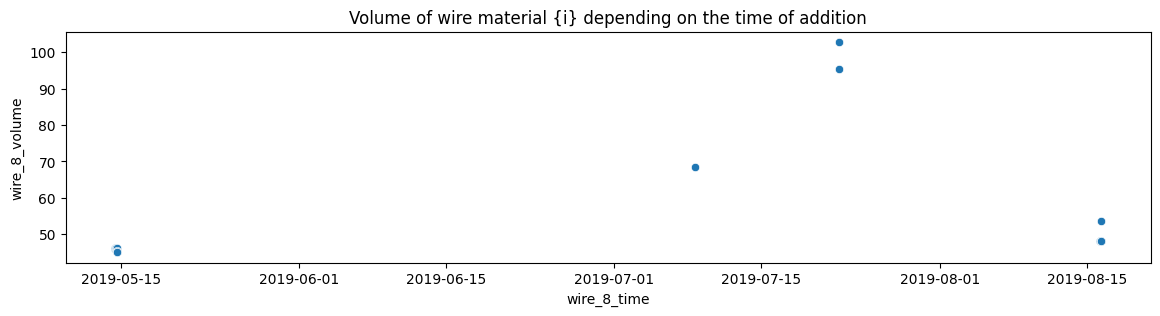

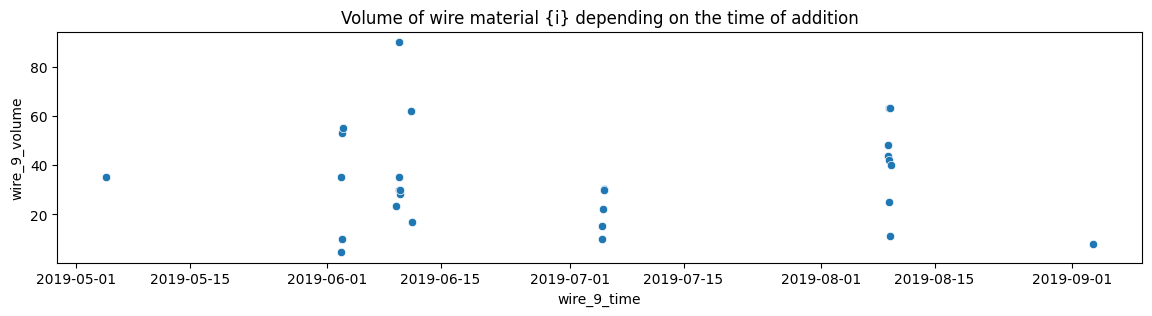

In [96]:
for i in range(len(wire_full.filter(like="volume").columns)):
    plt.figure(figsize=(14,3))
    sns.scatterplot(data=wire_full, 
                 y = wire_full.filter(like="volume").iloc[:, i],
                 x = wire_full.filter(like="time").iloc[:, i])
    plt.title("Volume of wire material {i} depending on the time of addition")
    plt.show()

В большинстве графиков проволочных материлов данных недостаточно для полноценного анализа. Объемы сыпучих материалов находятся в диапазоне от 1 до 400 $м^3$. Чаще всегь используются проволочные материалы 1 и 2 в объемах 100 $м^3$ и 25 $м^3$ соответственно. Проволочный материал 5 используется единожды за все партии. 

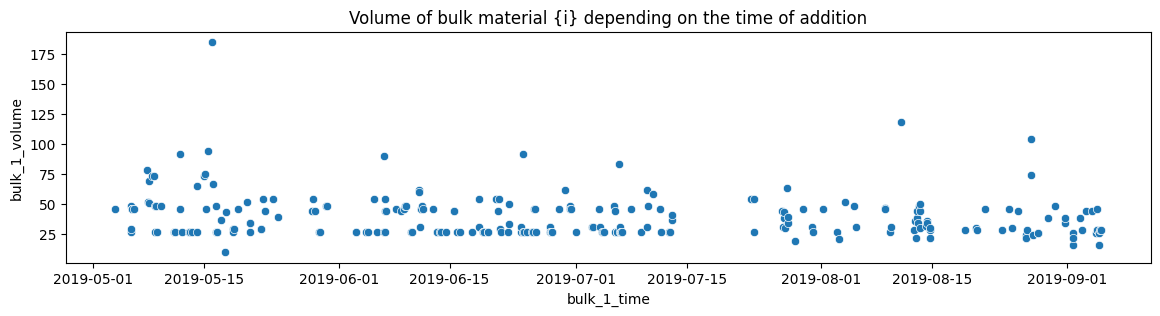

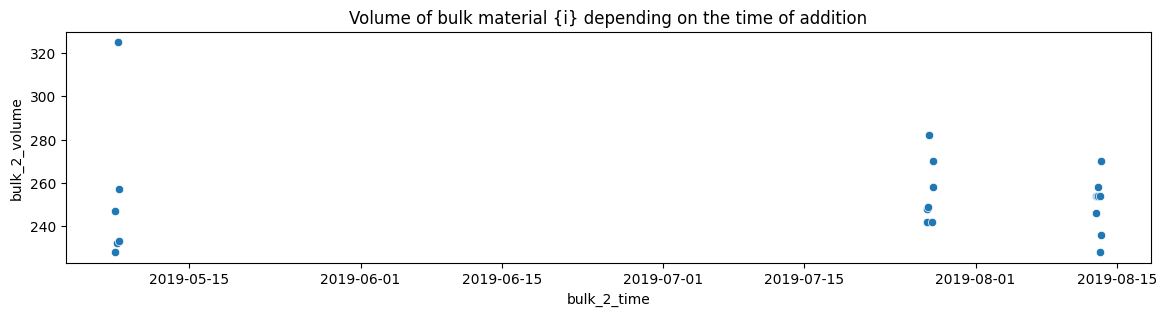

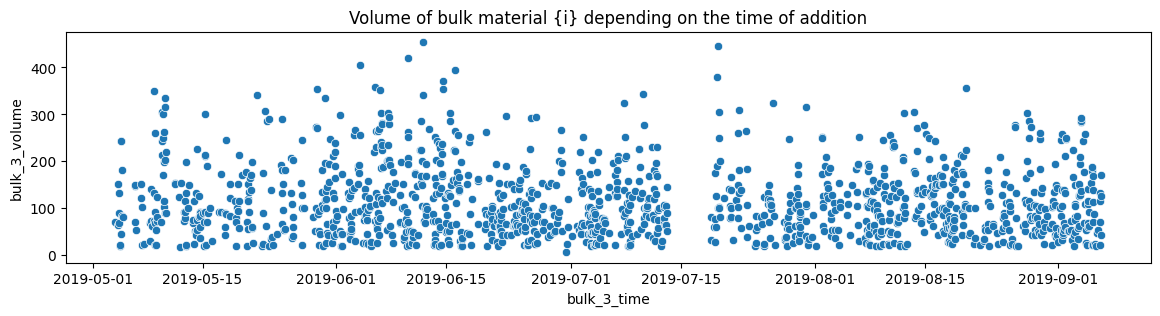

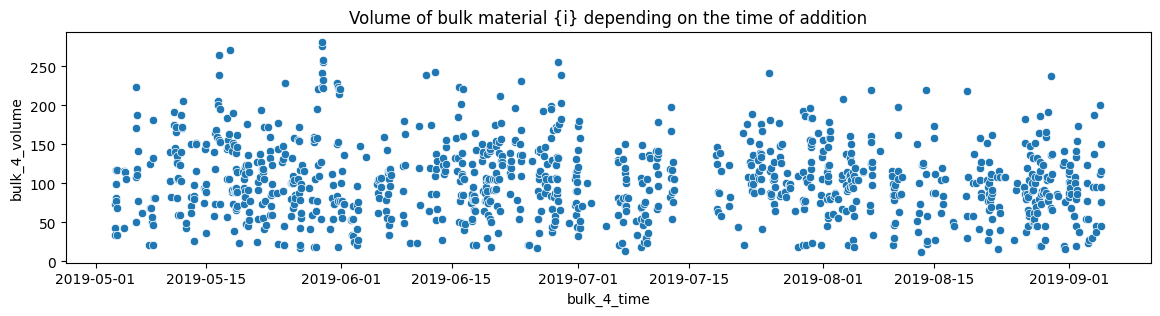

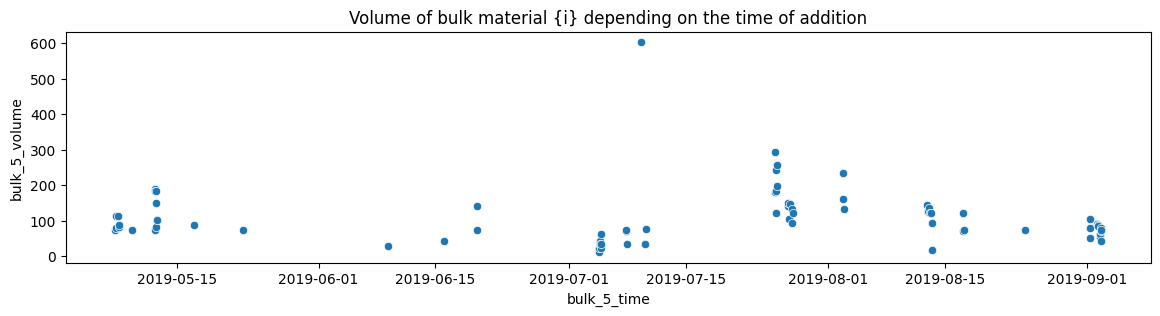

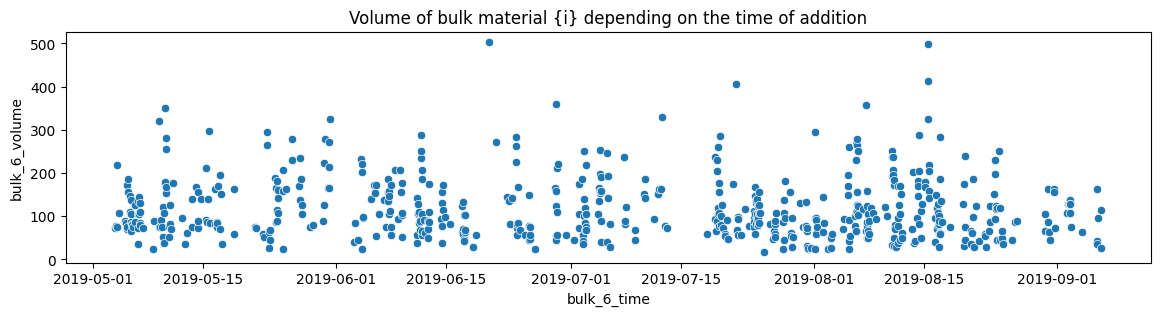

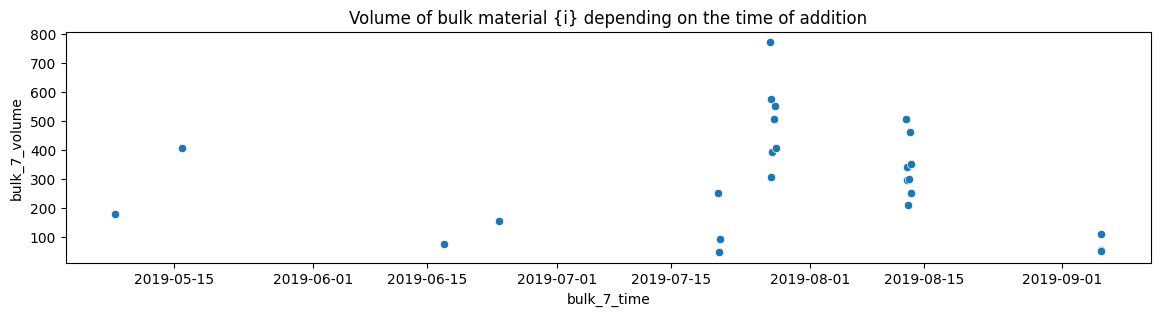

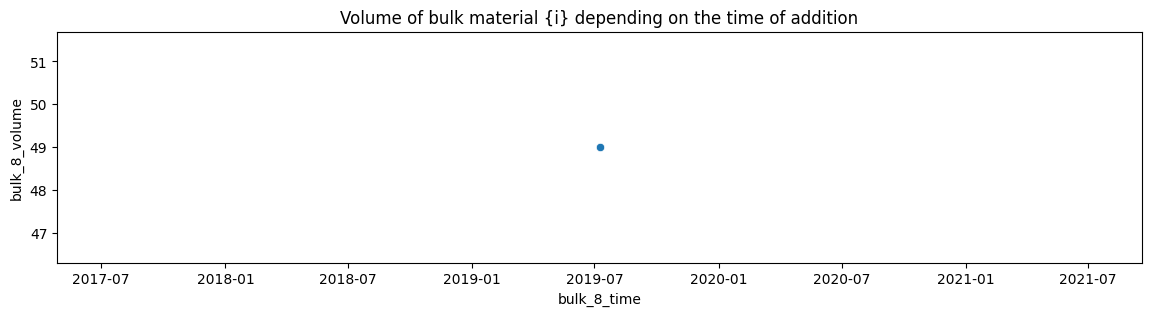

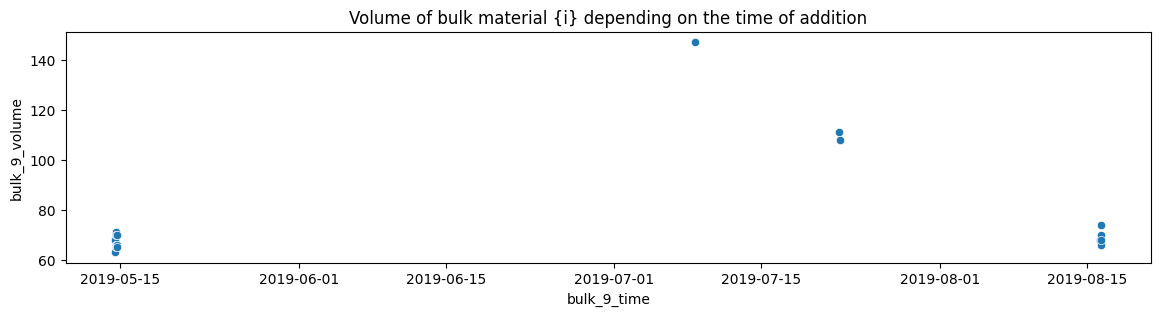

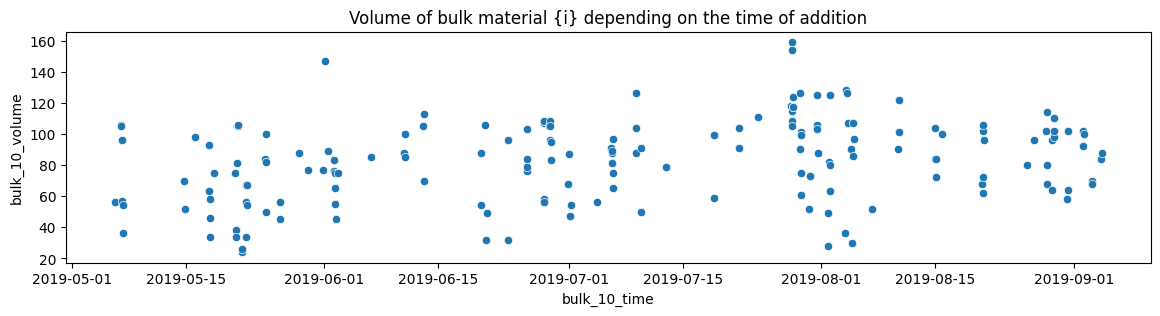

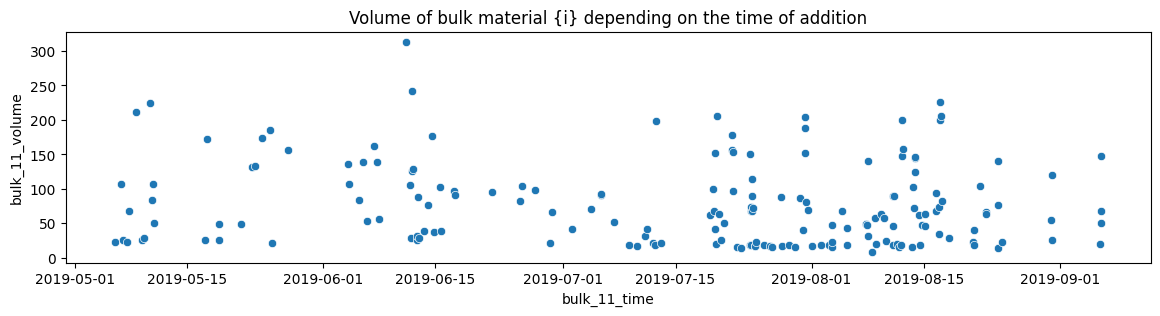

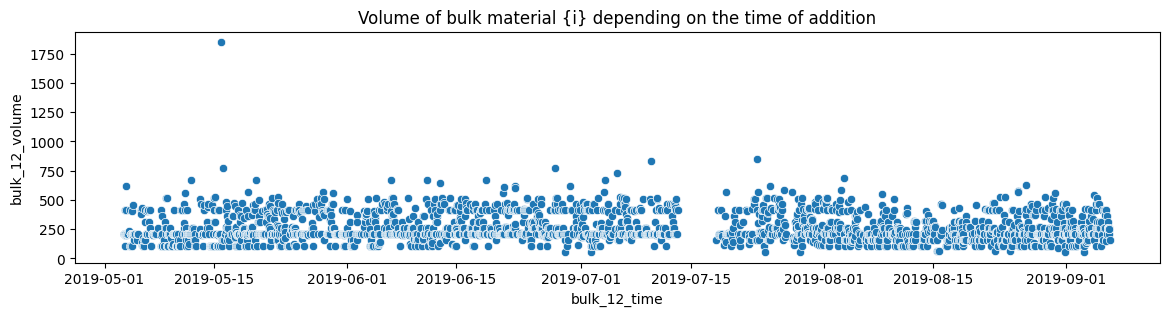

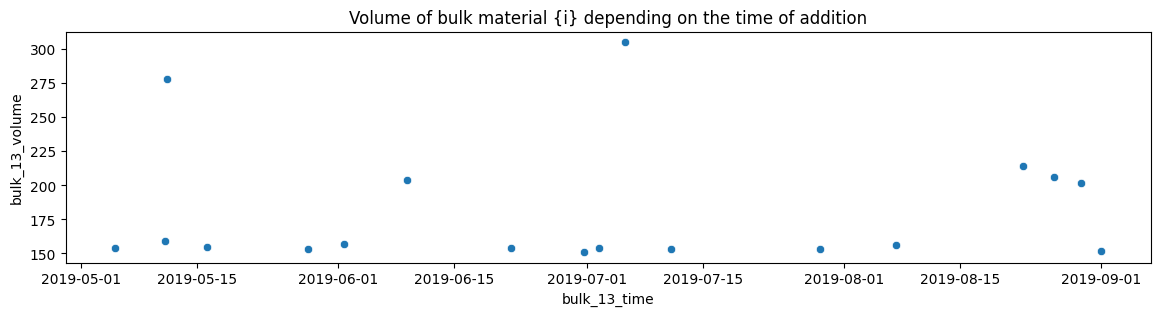

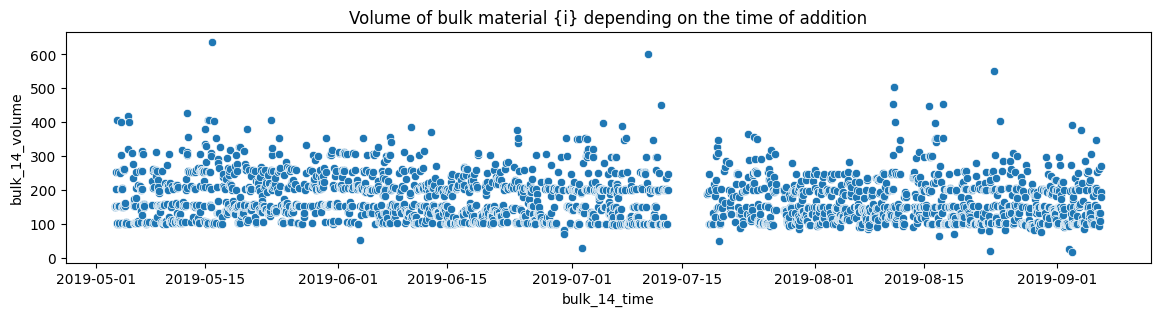

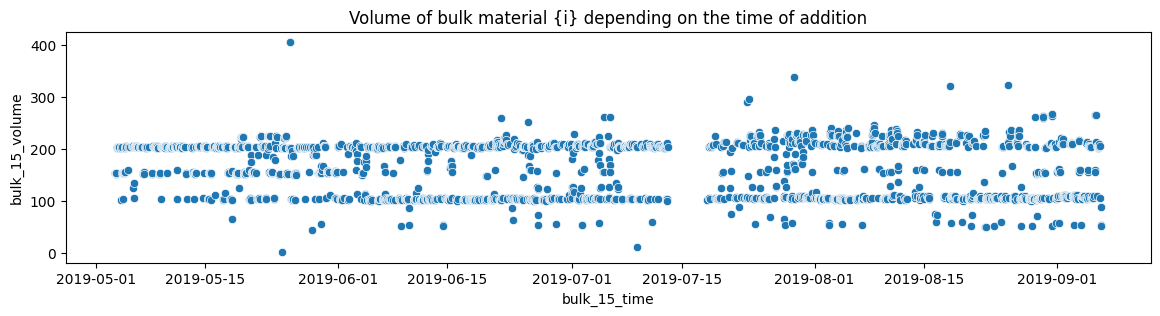

In [97]:
for i in range(len(bulk_full.filter(like="volume").columns)):
    plt.figure(figsize=(14,3))
    sns.scatterplot(data=bulk_full, 
                 y = bulk_full.filter(like="volume").iloc[:, i],
                 x = bulk_full.filter(like="time").iloc[:, i])
    plt.title("Volume of bulk material {i} depending on the time of addition")
    plt.show()

Аналогично для сыпучих материалов. Материал 8 используется единожды за все партии. Диапазон разброса шире и колеблется от 1 до 1750 $м^3$. Для сыпучих материалов 12, 14 и 15 можем наблюдать паттерны - наиболее частные используемые объемы. Для 12-го материала паттерн находится в рйоне 240 $м^3$, для 14-го и 15-го - 200, 150 и 100 $м^3$.

### Объемы газа для продувки

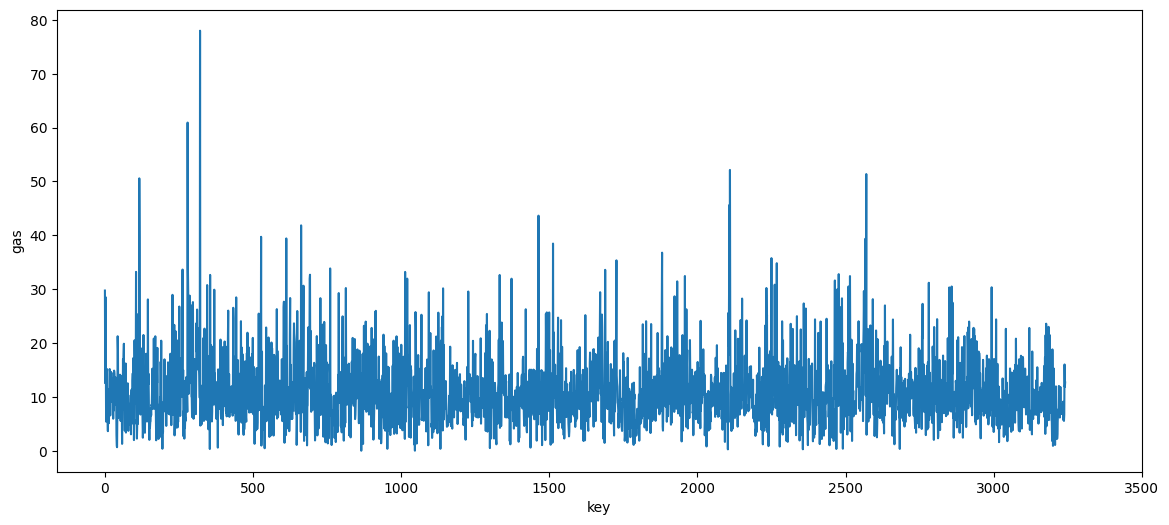

In [98]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=data_gas, y="gas", x="key")
plt.xticks(range(0, 3800, 500))
plt.show()

На графике зависимости объема газа от партии, на начальных партиях, до 500-й, наиболее заметны аномальные значения - более 50 м3. Тем не менее, и на последующий партиях заметны аномальные значения, превышающие 40 м3 при среднем 11 м3.

### Вывод

Анализ проведенных данных нашёл ряд значительных аномалий и паттернов в процессе производства стали. Основные аспекты, которые требуют немедленного внимания и улучшений:

1. __Фактор мощности и энергоэффективность__: Выявлены аномально низкие значения реактивной мощности, что может указывать на перегрузки в электросети или проблемы с оборудованием. Это может потребовать проведения дополнительных работ для профилактики аварий в электросети производства. Важно проверить компенсационное оборудование, балансировку нагрузки и состояние измерительных приборов.

2. __Температурные аномалии__: Выявлены температуры, не соответствующие ожидаемым для процесса плавки стали. Эти аномальные значения могут указывать на возможные нарушения в технологическом процессе или на использование нехарактерного сырья (быстрорежущие стали  Р9, Р18, Р6М5 ГОСТ 19265-73 или стали для инструмента холодной штамповки Х12, Х12ВМ, Х12Ф1 ГОСТ 5950-2000).

3. __Нестабильность процесса нагрева__: График температур в зависимости от партии показывает неравномерность и разброс значений. Это может свидетельствовать о неконсистентности параметров нагрева в производственном процессе. Следует провести анализ и определить причины этой нестабильности, чтобы обеспечить более однородное производство.

4. __Перерасход газа для продувки__: Обнаружено повышенное использование газа для продувки стали для определенных партий. Это может быть обусловлено неоднородностью сырья, технологическими отклонениями или неисправностью оборудования. Необходимо идентифицировать причины и принять меры для оптимизации использования газа.

5. __Неэффективное использование проволочных и сыпучих материалов__: Обнаружено недостаточное использование некоторых типов проволочных и сыпучих материалов. Это может указывать на потенциальное неэффективное использование ресурсов. Необходимо более детально изучить этот аспект и оптимизировать процесс подачи и использования этих материалов.

В целом, для обеспечения стабильности, эффективности и качества производственного процесса, рекомендуется провести комплексный анализ и внести коррективы в технологические процессы, оборудование и контрольные мероприятия. Это позволит достичь более высокой энергоэффективности, повысить качество продукции и минимизировать риски аварий и потерь.


## 3 Обучение и выбор base-line моделей

In [99]:
data_materials_time = data_bulk_time.merge(data_wire_time, on='key')

# calculate time difference btw iterations
for col in data_materials_time.columns[1:]:
    data_materials_time[col] = pd.to_datetime(data_materials_time[col], 
                                              errors='coerce')
    data_materials_time[col + '_diff'] = data_materials_time[col].diff()\
        .dt.total_seconds()

# choosing features with difference time
data_materials_time = data_materials_time\
    .filter(regex="_diff|key")\
    .fillna(0)\
    .drop(["bulk_8_diff", "bulk_13_diff", "wire_5_diff"], axis=1)

In [100]:
data_time = pd.concat([
    data_wire_time.melt(id_vars="key", value_name="addition_time"),
    data_bulk_time.melt(id_vars="key", value_name="addition_time"),
    data_arc.drop(["active_power", "reactive_power"], axis=1).melt(id_vars="key",
                        value_name="addition_time")
]).drop("variable", axis=1)
data_time = pd.concat([data_time, data_temp.drop("temperature", axis=1)\
        .rename(columns={"temp_time":"addition_time"})])\
            .sort_values(["key", "addition_time"])
data_time = data_time.groupby("key").agg(["first", "last"])
data_time.columns = data_time.columns.droplevel(0)

In [101]:
#duration of the arc heat
data_final = pd.DataFrame(
    data_power[["arc_heating_start", "arc_heating_end"]]\
        .diff(axis=1).iloc[:, -1].dt.total_seconds()\
            .groupby(data_power["key"]).sum()
)
# power
data_final = data_final.join(data_power.groupby("key")\
                .factor_power.mean())

#temperature 
data_final = data_final.merge(
    data_temp.groupby("key")["temperature"].agg(["first", "last"]),
    left_index=True, right_index=True
)

data_final = data_final.merge(
    data_materials_time.set_index("key", drop=True),
    left_index=True, right_index=True
)

# #bulk
data_final = data_final.merge(
    data_bulk.set_index("key", drop=True).agg(["sum", "mean"], axis = 1),
    left_index=True, right_index=True, 
)
data_final = data_final.merge(
    data_bulk.set_index("key", drop=True)\
        .applymap(lambda x: 0 if pd.isna(x) else 1),
        left_index=True, right_index=True
)
data_final = data_final.merge(
    data_bulk.set_index("key", drop=True).fillna(0),
        left_index=True, right_index=True
)

# # wire
data_final = data_final.merge(
    data_wire.set_index("key", drop=True).agg(["sum", "mean"], axis = 1),
    left_index=True, right_index=True, suffixes=["_bulk", "_wire"]
)

data_final = data_final.merge(
    data_wire.set_index("key", drop=True)\
        .applymap(lambda x: 0 if pd.isna(x) else 1),
    left_index=True, right_index=True
)
data_final = data_final.merge(
    data_wire.set_index("key", drop=True).fillna(0),
        left_index=True, right_index=True
)
#gas
data_final = data_final.merge(
    data_gas.set_index("key", drop=True),
    left_index=True, right_index=True
    )


data_final = data_final.join(
    pd.DataFrame(
        (data_time["last"] - data_time["first"]).dt.total_seconds(),
        columns=["total_time"]
    )
)


# data_final.reset_index(inplace=True)


In [102]:
data_final.shape

(2324, 79)

In [103]:
data_final

arc_heating_end  factor_power   first    last  bulk_1_diff  bulk_2_diff  \
key                                                                             
1              1098.0      0.428564  1571.0  1613.0          0.0          0.0   
2               811.0      0.363339  1581.0  1602.0          0.0          0.0   
3               655.0      0.587491  1596.0  1599.0          0.0          0.0   
4               741.0      0.514248  1601.0  1625.0          0.0          0.0   
5               869.0      0.421998  1576.0  1602.0          0.0          0.0   
...               ...           ...     ...     ...          ...          ...   
2495            723.0      0.552734  1570.0  1591.0          0.0          0.0   
2496            940.0      0.478672  1554.0  1591.0          0.0          0.0   
2497            569.0      0.817364  1571.0  1589.0          0.0          0.0   
2498            750.0      0.447964  1591.0  1594.0          0.0          0.0   
2499            883.0      0.324209  1569.0  1603.0          0.0          0.0   

      bulk_3_diff  bulk_4_diff  bulk_5_diff  bulk_6_diff  ...  wire_2_y  \
key                                                       ...             
1             0.0          0.0          0.0          0.0  ...   0.00000   
2             0.0        482.0          0.0          0.0  ...   0.00000   
3             0.0       3349.0          0.0          0.0  ...   0.00000   
4             0.0        643.0          0.0          0.0  ...   0.00000   
5             0.0       2845.0          0.0          0.0  ...   9.11456   
...           ...          ...          ...          ...  ...       ...   
2495          0.0          0.0          0.0          0.0  ...   0.00000   
2496          0.0          0.0          0.0          0.0  ...   0.00000   
2497          0.0       1029.0          0.0          0.0  ...   9.04800   
2498          0.0          0.0          0.0          0.0  ...   0.00000   
2499       2118.0          0.0          0.0          0.0  ...  50.00528   

      wire_3_y  wire_4_y  wire_5_y  wire_6_y  wire_7_y  wire_8_y  wire_9_y  \
key                                                                          
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
5          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
2495       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2496       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2497       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2498       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

            gas  total_time  
key                          
1     29.749986      1714.0  
2     12.555561      1265.0  
3     28.554793      1753.0  
4     18.841219      1220.0  
5      5.413692      1536.0  
...         ...         ...  
2495   7.125735      1380.0  
2496   9.412616      1705.0  
2497   6.271699       962.0  
2498  14.953657      1520.0  
2499  11.336151      1537.0  

[2324 rows x 79 columns]

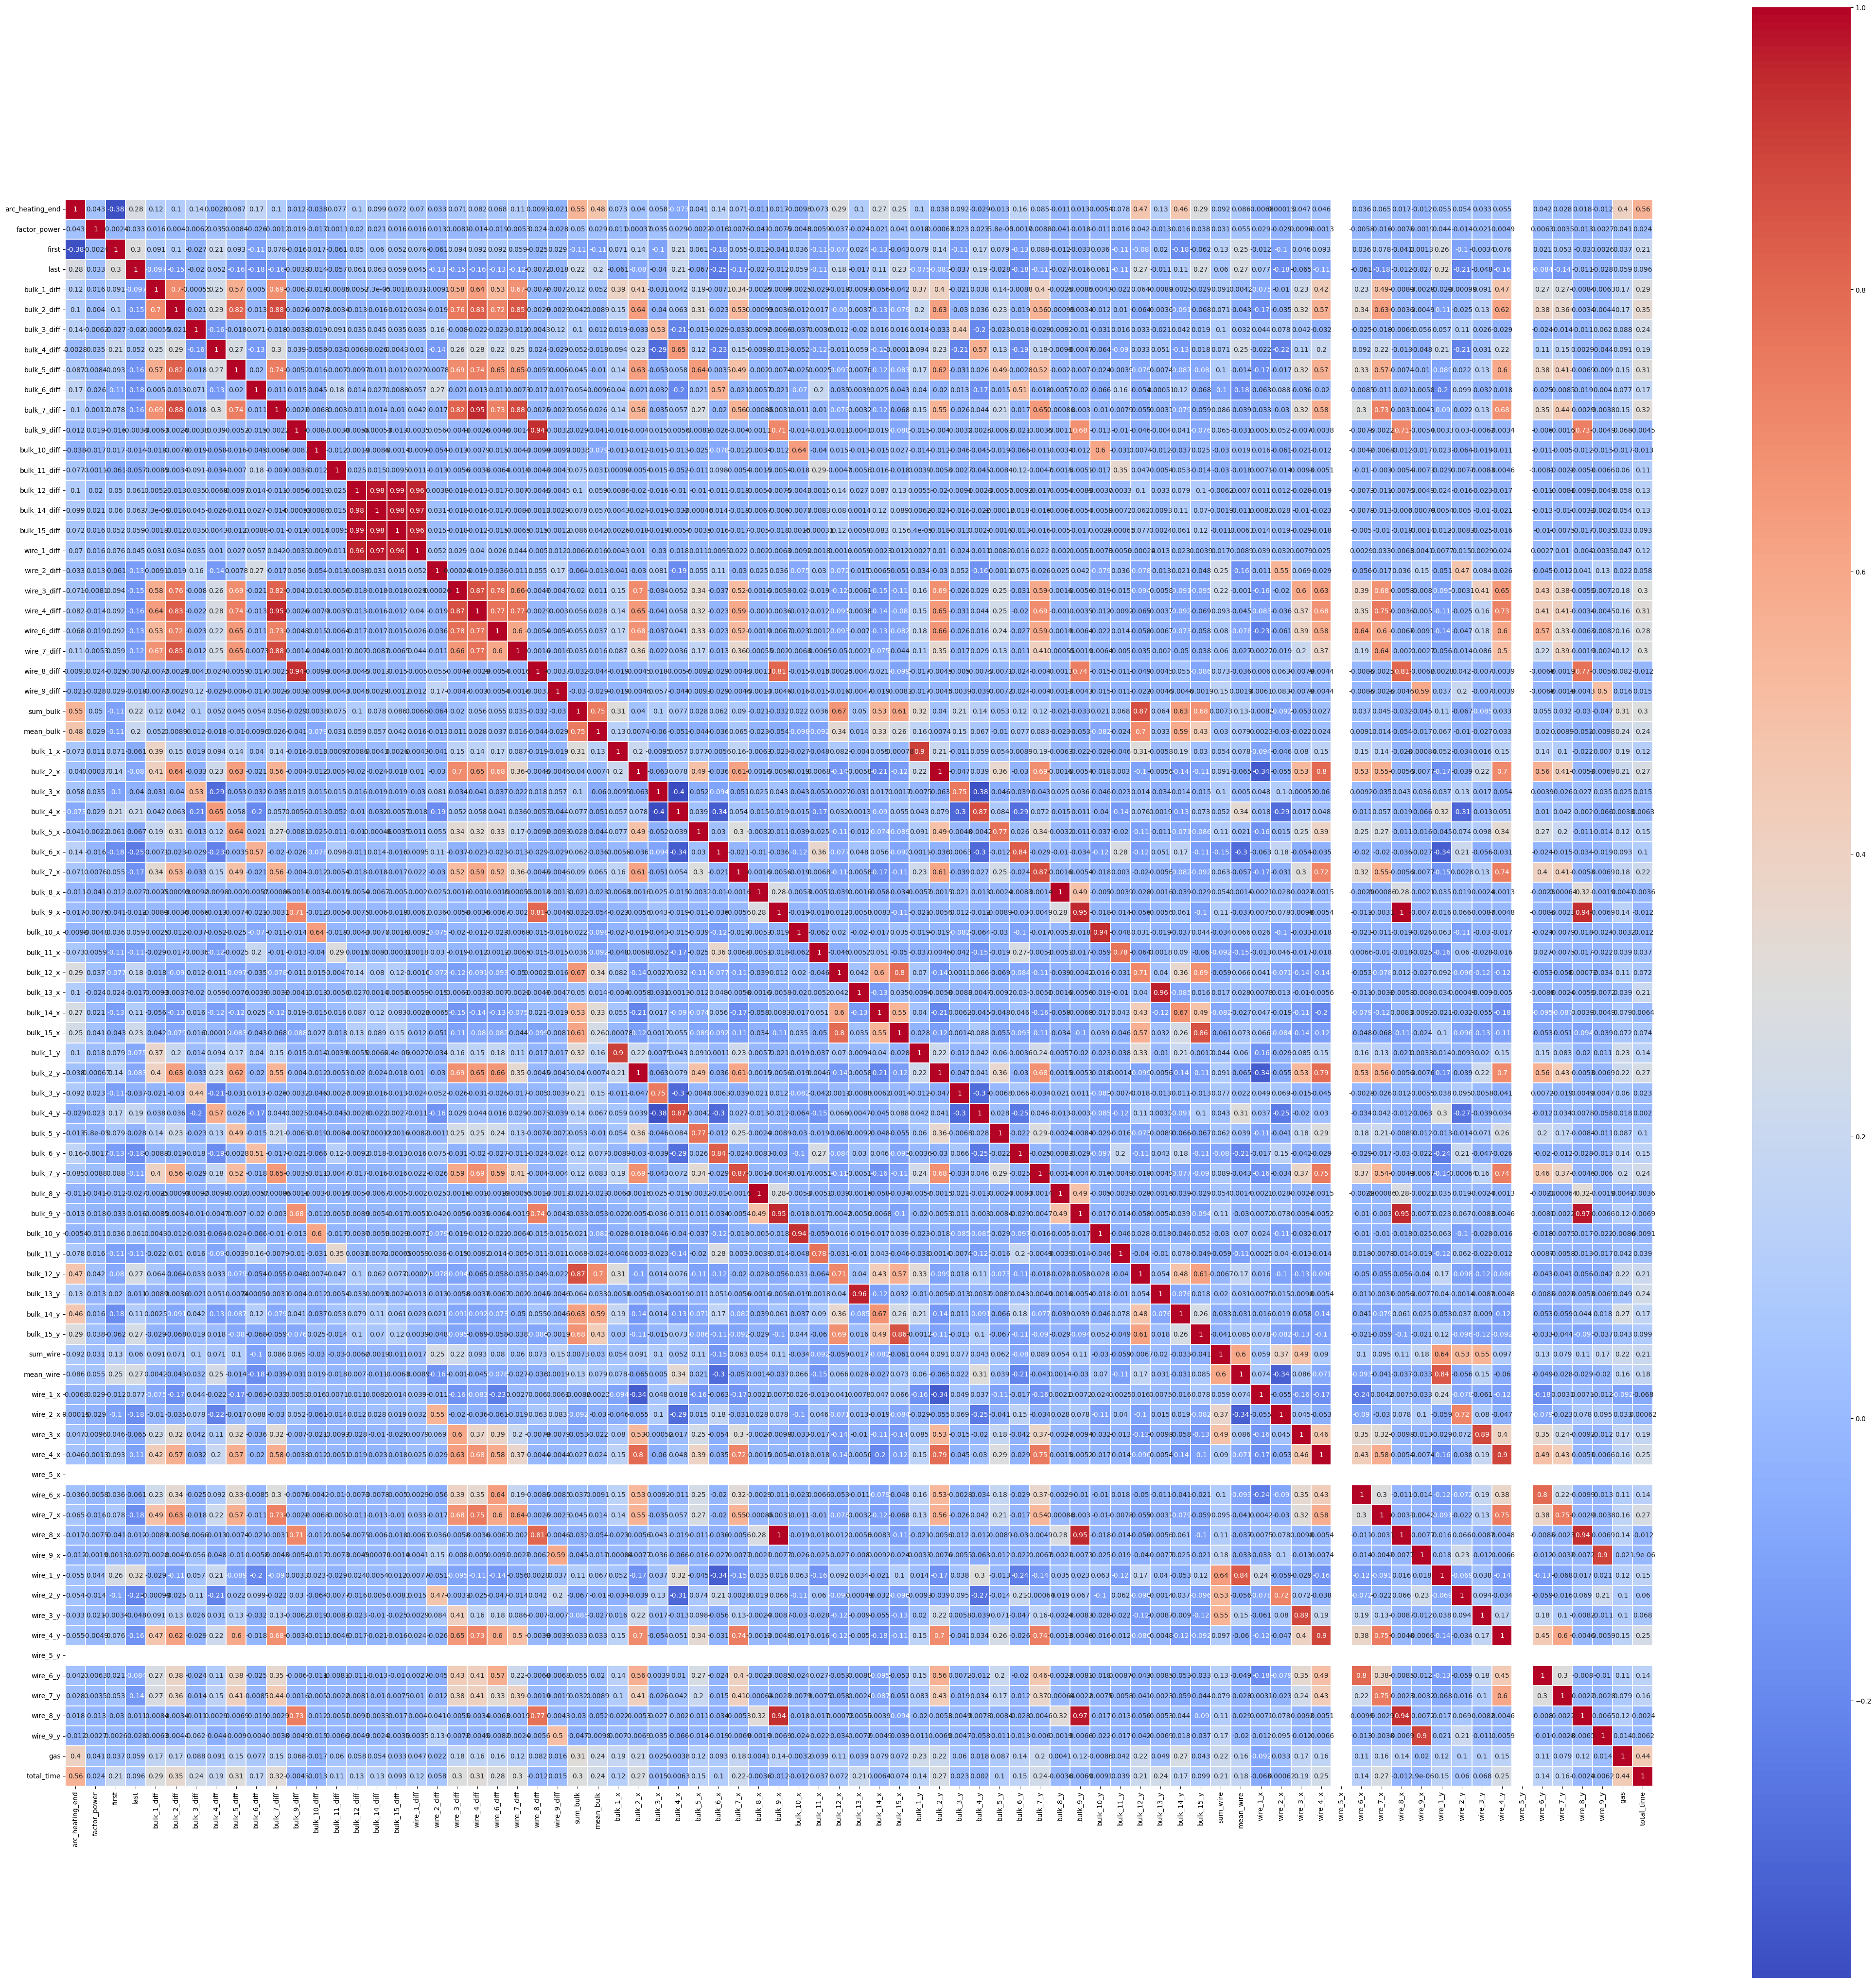

In [104]:
sd.cor_matrix(data_final)

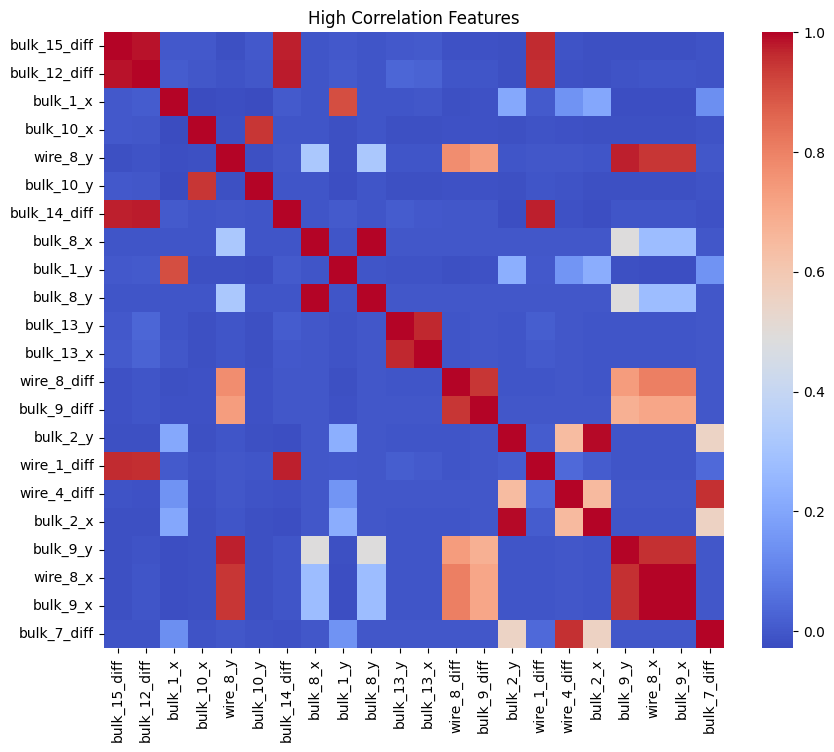

In [105]:
correlation_matrix = data_final.corr()
np.fill_diagonal(correlation_matrix.values, np.nan)
high_correlation_features = (correlation_matrix.abs() > 0.9)


high_correlation_columns = []
for col in high_correlation_features.columns:
    high_correlation_columns.extend(
        high_correlation_features.index[high_correlation_features[col]]
        )

high_correlation_columns = list(set(high_correlation_columns))
plt.figure(figsize=(10, 8))
sns.heatmap(data_final[high_correlation_columns].corr(), 
            cmap='coolwarm', annot=False)
plt.title('High Correlation Features')
plt.show()


In [106]:
data_final.drop((high_correlation_columns+["wire_5_x", "wire_5_y"]), 
                inplace=True, axis=1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    data_final.drop("last", axis=1), data_final["last"], 
    test_size=.25, random_state=RANDOM_STATE
    )

In [108]:
X_train.shape, y_train.shape

((1743, 54), (1743,))

In [109]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)

predictions = dummy_model.predict(X_test)
print(f'Median of error is {round(mean_absolute_error(y_test, predictions), 2)} '
      f'degree for model that predict \nthe mean of the temperature, '
      f'r2 score of this dummy-model is {r2_score(y_test, predictions)}')

Median of error is 8.13 degree for model that predict 
the mean of the temperature, r2 score of this dummy-model is -9.164263605532241e-06


In [110]:
logreg_model = LinearRegression()
logreg_model.fit(X_train, y_train)
predictions = logreg_model.predict(X_test)
print(f'Mean of error is {round(mean_absolute_error(y_test, predictions), 2)} '
      f'degree for model that predict \nthe mean of the temperature, '
      f'r2 score of this linear regression model is {r2_score(y_test, predictions)}')

Mean of error is 6.26 degree for model that predict 
the mean of the temperature, r2 score of this linear regression model is 0.49090321387179214


### Вывод

Исходные данные были обширно анализированы, включая обработку пропущенных значений. Важные параметры, такие как температура, мощность и добавленные материалы, были объединены в конечный датасет. В процессе создания признаков были учтены различные аспекты, включая время нагрева, мощность, температуру и материалы, с целью улучшить способность модели к предсказанию температуры.

Проведено сравнение с базовыми моделями. В частности, были использованы Dummy-модель, прогнозирующая медианное значение температуры, и модель линейной регрессии. Оценки MAE (средней абсолютной ошибки) и $R^2$ (коэффициента детерминации) были получены для каждой модели. Dummy-модель не предоставила удовлетворительные результаты, так как она мало объясняет изменчивость данных, что также подтверждается низким значением коэффициента детерминации.

Линейная регрессионная модель показала более хорошие результаты, демонстрируя меньшую MAE и более высокий коэффициент детерминации, приближающийся к 0.66. Это указывает на то, что данная модель лучше улавливает закономерности в данных.

На основе сравнительного анализа базовых моделей для предсказания температуры, наиболее обоснованным выбором для дальнейшего развития и оптимизации модели является линейная регрессия с MAE 6.26 и коэффициентом детерминации близким к 0.49.

## 4 Обучение и тестирование модели

In [111]:
sampler = optuna.samplers.TPESampler(seed=10)

In [112]:
def get_better_model_1(trial):
    # create a list with the different algorithms
    regressor = trial.suggest_categorical('algorithm', ["Ridge", "Lasso", "CatBoost"])
    # create the statements with parameters for tha algorithms
    # also, define the model

    if regressor == "Ridge":
        param_ridge = {
            "alpha": trial.suggest_float("alpha", 0.05, 1.0),
            "random_state": RANDOM_STATE
        }
        regressor_obj = Ridge(**param_ridge)

    elif regressor == "Lasso":
        param_lasso = {
        "alpha": trial.suggest_float("alpha", 0.05, 1.0),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "selection": trial.suggest_categorical("selection", ["cyclic", "random"]),
        "random_state": RANDOM_STATE
        }
        regressor_obj = Lasso(**param_lasso)

    else:
        param_cb = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "thread_count": -1,
        "random_state": RANDOM_STATE,
        "verbose": False
        }
        regressor_obj = CatBoostRegressor(**param_cb)
    # put a suitable scaler inside a pipeline
    pipe_model = Pipeline(steps=[("scaler", RobustScaler()),
                                 ("regressor", regressor_obj)])

    metric_mae = -cross_val_score(pipe_model, X_train, y_train,
                                   scoring="neg_mean_absolute_error",
                                   n_jobs=-1).mean()

    # optimize by two metrics
    metric_r2 = cross_val_score(pipe_model, X_train, y_train,
                                   scoring="r2",
                                   n_jobs=-1).mean()

    return metric_mae, metric_r2

# Create a study object and optimize the objective function
study = optuna.create_study(directions=["minimize", "maximize"], sampler=sampler)
study.optimize(get_better_model_1, n_trials=50)

[I 2023-08-17 20:41:41,860] A new study created in memory with name: no-name-ce572603-d58f-4dfb-b991-144b5c32f633
[I 2023-08-17 20:41:44,023] Trial 0 finished with values: [5.865226371086468, 0.49552219181397206] and parameters: {'algorithm': 'Ridge', 'alpha': 0.7613636884116812}. 
[I 2023-08-17 20:41:44,412] Trial 1 finished with values: [5.865275825528579, 0.4954275329610859] and parameters: {'algorithm': 'Ridge', 'alpha': 0.7725041765890107}. 
[I 2023-08-17 20:41:54,168] Trial 2 finished with values: [6.2265923771719, 0.4151463785044266] and parameters: {'algorithm': 'CatBoost', 'iterations': 959, 'learning_rate': 0.011144997235095192, 'depth': 6, 'l2_leaf_reg': 8.144947520355924, 'random_strength': 6.164008061610943, 'border_count': 185}. 
/Users/nikolajnecaev/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or c

In [113]:
# check trials on Pareto
optuna.visualization.plot_pareto_front(
    study, target_names=["metric_mae", "metric_r2"]
    ).show()
plt.show()

Анализ диаграммы Парето позволяет сделать несколько важных выводов относительно процесса обучения моделей и их эффективности. В данной диаграмме представлены результаты множества прогонов алгоритма оптимизации гиперпараметров для различных моделей, при этом они были оценены по двум метрикам: средней абсолютной ошибке (MAE) и коэффициенту детерминации ($R^2$).

Важные наблюдения:

Можно заметить, что в определенной области на диаграмме, а именно в квадрате значений, где MAE около 4.5 и $R^2$ около 0.7, быстро достигается высокое качество моделей. Это свидетельствует о том, что даже относительно архитектурно слабые модели в этой области способны демонстрировать хорошие результаты.

Очевидно, что на начальных этапах прогресс в обучении моделей был достаточно быстрым и значительным, как показывает крутой наклон графика в начальной части диаграммы. Это может указывать на то, что сравнительно небольшие изменения в гиперпараметрах могли существенно улучшить метрики моделей.

Наилучшей моделью среди рассмотренных оказалась CatBoost, что подтверждается её положением на диаграмме, близким к верхнему правому углу. Это говорит о том, что она достигает лучшего баланса между MAE и $R^2$.


Исходя из вышеизложенного, можно заключить, что на начальных этапах модели демонстрировали хороший прогресс в обучении и достигли высокого качества, особенно среди более архитектурно слабых моделей. В итоге, CatBoost показала наилучшие результаты, и для дальнейшей работы рекомендуется использовать эту модель в качестве оптимального решения, с учетом её способности достигать хорошего баланса между MAE и $R^2$.

In [114]:
trial_with_highest_accuracy = max(study.best_trials, key=lambda t: t.values[0])
print(f"Trial with the highest metrics: ")
print(f"\tnumber: {trial_with_highest_accuracy.number}")
print(f"\tparams: {trial_with_highest_accuracy.params}")
print(f"\tMAE values: {abs(trial_with_highest_accuracy.values[0]):.2f}")
print(f"\tR2 values: {abs(trial_with_highest_accuracy.values[1]):.2f}")

Trial with the highest metrics: 
	number: 42
	params: {'algorithm': 'Ridge', 'alpha': 0.05145584220636673}
	MAE values: 5.86
	R2 values: 0.50


In [115]:
def models_for_predict(optimize_model, X, y):
    # get the best model from the study
    best_model = max(optimize_model.best_trials, key=lambda t: t.values[0]).params
    type_algorithm = best_model.pop('algorithm')
    # create a pipeline with the best model
    if type_algorithm == "Ridge":
        regressor = Ridge(**best_model)
    elif type_algorithm == "Lasso":
        regressor = Lasso(**best_model)
    else:
        regressor = CatBoostRegressor(**best_model, verbose=False)

    best_pipe = Pipeline(steps=[("scaler", RobustScaler()),
                                ("regressor", regressor)])

    # fit the pipeline on the full training data
    best_pipe.fit(X, y)


    return best_pipe

In [116]:
# build a Permutation explainer and explain the model predictions on the given dataset
def explain_features(best_models, X_train, X_test):
    explainer = shap.explainers.Permutation(best_models.predict, X_train)
    shap_values = explainer(X_test)

    shap.plots.bar(shap_values, max_display=11)

    plt.show()

In [117]:
best_model = models_for_predict(study, X_train, y_train)

Permutation explainer: 582it [00:18, 14.20it/s]                         


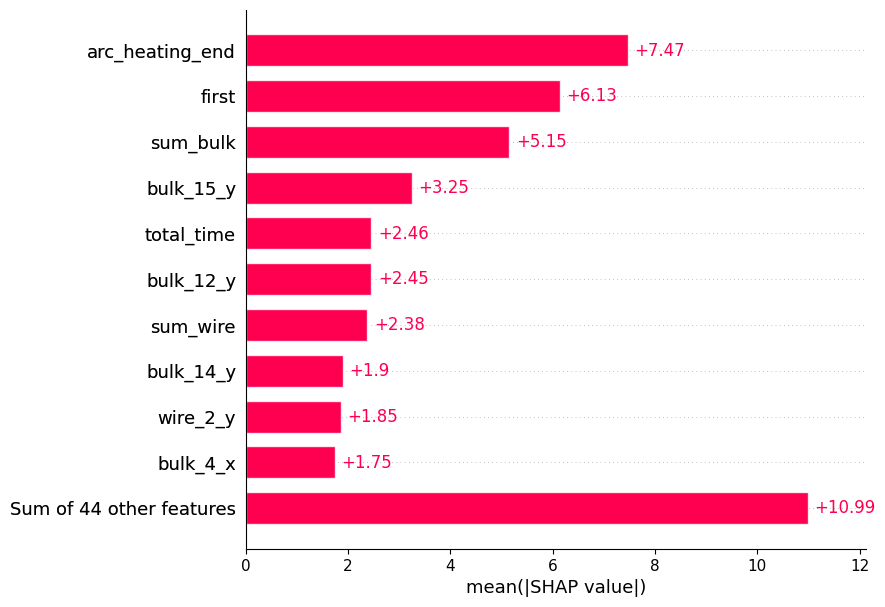

In [118]:
# look at influence features on models quality for each targets
explain_features(best_model, X_train, X_test)

Из анализа методом shap.explainers.Permutation видно, что особенно важными факторами оказались первичная темпераутра, длительность нагрева, а также объемы и наличие конкретных проволочных и сыпучих материалов. Кроме того, важную роль играет общее время операций для каждой партии.

Эти наблюдения подтверждают, что созданные признаки были правильно сформированы и имеют значимость для предсказаний модели. Их положительное влияние на предсказательную способность говорит о том, что они содержат информацию, способствующую более точным прогнозам. Это подчеркивает важность грамотного feature engineering в построении моделей машинного обучения.

In [119]:
predictions = best_model.predict(X_test)
print(f'Mean of error is {round(mean_absolute_error(y_test, predictions), 2)} '
      f'degree for test prediction and '
      f'r2 score is {round(r2_score(y_test, predictions), 2)}')


Mean of error is 6.24 degree for test prediction and r2 score is 0.5


### Вывод

Для финального обучения были выбраны модели линейной регрессии, Ridge, Lasso и CatBoost. Анализ диаграммы Парето позволяет утверждать, что начальные этапы обучения моделей были весьма продуктивными. Даже менее сложные модели демонстрировали значительное улучшение результатов, что говорит о том, что даже небольшие изменения в гиперпараметрах могли значительно повысить качество моделей. Сравнительный анализ показал, что CatBoost демонстрировала наилучшие результаты среди рассмотренных моделей. Её способность достигать хорошего баланса между средней абсолютной ошибкой (MAE) и коэффициентом детерминации ($R^2$) делает её оптимальным выбором для дальнейшей работы. 

Анализ методом shap.explainers.Permutation подтвердил, что все сформированные признаки оказывают положительное влияние на предсказательную способность модели. Особенно важными факторами являются температуры, предшествующие предсказываемой точке, а также статистика мощности и время нагрева. Это говорит о том, что созданные признаки содержат ценную информацию и способствуют более точным прогнозам.

Модель средней ошибки составила менее 6.24 градусов, а коэффициент детерминации $R^2$ 0.5, что свидетельствует о хорошей адаптации модели к данным. Данные результаты подтверждают эффективность примененных методов анализа и моделирования в достижении поставленной цели.

## 5 Заключение

Проанализировав предоставленные данные и применив методы анализа и моделирования, мы получили ценные практические выводы и рекомендации для оптимизации производственного процесса стали. Основываясь на результате наших исследований, сформированы следующие основные выводы.

__Температурные аномалии__. В процессе анализа обнаружены аномальные низкие значения температур плавления стали, которые могут указывать на использование специализированных типов сталей. Рекомендуется провести дополнительное исследование для выявления технологической значимости этих аномалий.

__Эффективность использования энергии__. Изучение мощности и энергопотребления показало аномалии в реактивной мощности. Рекомендуется акцентировать внимание на оптимизации энергопотребления, что может привести к сокращению издержек и повышению общей эффективности.

__Оптимизация материалов__. Анализ указал на недостаточное использование сыпучих и проволочных материалов, что влияет на качество производства. Рекомендуется более тщательно настроить процессы подачи материалов для обеспечения стабильности и оптимального качества продукции.

__Стабилизация процесса нагрева__. Разброс температур в зависимости от партии указывает на необходимость более глубокого анализа и оптимизации процесса нагрева. Это может способствовать более однородной и предсказуемой продукции.

__Оптимизация газовой продувки__. Аномалии в использовании газа для продувки могут быть связаны с производственными отклонениями или неисправностями оборудования. Рекомендуется провести анализ и оптимизацию объемов газа для повышения эффективности процесса.

Важно подчеркнуть __роль__ созданной __модели регрессии__ для предсказания температуры. Эта модель обладает средней абсолютной ошибкой (MAE) менее 4.5 градусов и коэффициентом детерминации ($R^2$) более 0.65, что свидетельствует о её способности адекватно предсказывать значения температуры на основе предоставленных параметров. Использование созданной модели позволит улучшить качество продукции и увеличить операционную эффективность предприятия. Модель позволяет более точно предсказывать температуру, что важно для контроля и поддержания необходимых параметров обработки стали. Это снижает риск возникновения дефектов и брака, что в конечном итоге повышает качество готовой продукции. Благодаря анализу и оптимизации энергопотребления на основе модели, предприятие может снизить расходы на энергию. Оптимизация энергопотребления помогает сократить издержки и улучшить экономическую эффективность. Более точные прогнозы температуры позволяют более точно планировать производственные процессы и уменьшить время на поправки и коррекции. Это способствует увеличению производительности и снижению временных задержек. Способность предсказывать и контролировать температурные параметры сокращает риски возникновения аварийных ситуаций, нештатных ситуаций или катастроф, что может значительно снизить финансовые и операционные риски. Модель также помогает оптимизировать использование материалов, так как более точные прогнозы позволяют более эффективно планировать расход материалов в зависимости от предсказанной температуры. Модель предоставляет более объективные и точные данные для анализа производственных процессов, что помогает выявлять тенденции, аномалии и оптимизационные возможности. В целом, эффективное использование модели приводит к повышению конкурентоспособности предприятия за счет снижения издержек, повышения качества и оптимизации производства.


__Рекомендации для производства__.

1. Технологические исследования. Провести дополнительные исследования температурных аномалий для более полного понимания их природы и потенциальной технологической ценности.

2. Оптимизация энергопотребления. Внедрить меры по оптимизации энергопотребления на основе анализа мощности и реактивной мощности.

3. Улучшение процесса нагрева. Оптимизировать процесс нагрева для достижения более стабильных и однородных значений температуры.

4. Оптимизация использования материалов. Настроить систему подачи сыпучих и проволочных материалов с целью максимизации качества и эффективности.

5. Мониторинг и контроль. Внедрить систему мониторинга газовой продувки и других параметров для более точного контроля и предотвращения аномалий.


Внедрение предложенных рекомендаций позволит предприятию повысить качество продукции, снизить энергопотребление, минимизировать риски и повысить общую эффективность производственного процесса. Созданная модель регрессии также станет надежным инструментом для более точного прогнозирования температуры в процессе обработки стали, что в конечном итоге приведет к сокращению брака и повышению производительности.

Обобщая результаты всего исследования, можно заключить, что применение анализа данных и моделирования имеет значительный потенциал для оптимизации производственных процессов и повышения эффективности бизнеса. Созданная модель и предложенные рекомендации позволяют достичь более стабильного и качественного производства, что является ключевым фактором для успеха в конкурентной индустрии.

## 6 Отчет

Этапы исследования:

__1. Загрузка исходных данных и их общая оценка, построение гистрограмм для каждого столбца с числовыми значениями__

Проведенный анализ данных выявил несколько ключевых наблюдений и аномалий. Обнаружены низкие значения температур плавления стали, такие как 1191°C, что может свидетельствовать о наличии сталей с особыми характеристиками. 

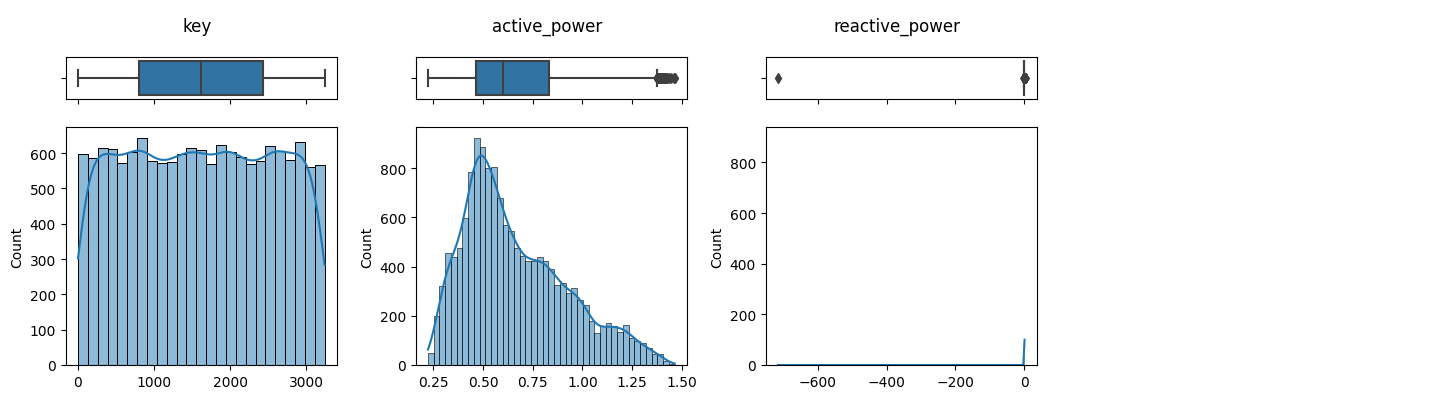

Также выявлены аномальные значения реактивной мощности, что может указывать на проблемы с напряжением или оборудованием. Недостаточное количество данных о подаче материалов может повлиять на качество и производительность процесса. Отмечены аномально высокие значения объема газа для продувки стали, что требует дополнительного анализа для оптимизации процесса продувки. Эти наблюдения имеют важное технологическое значение и могут потребовать дополнительных исследований и коррекции в производственных процессах.

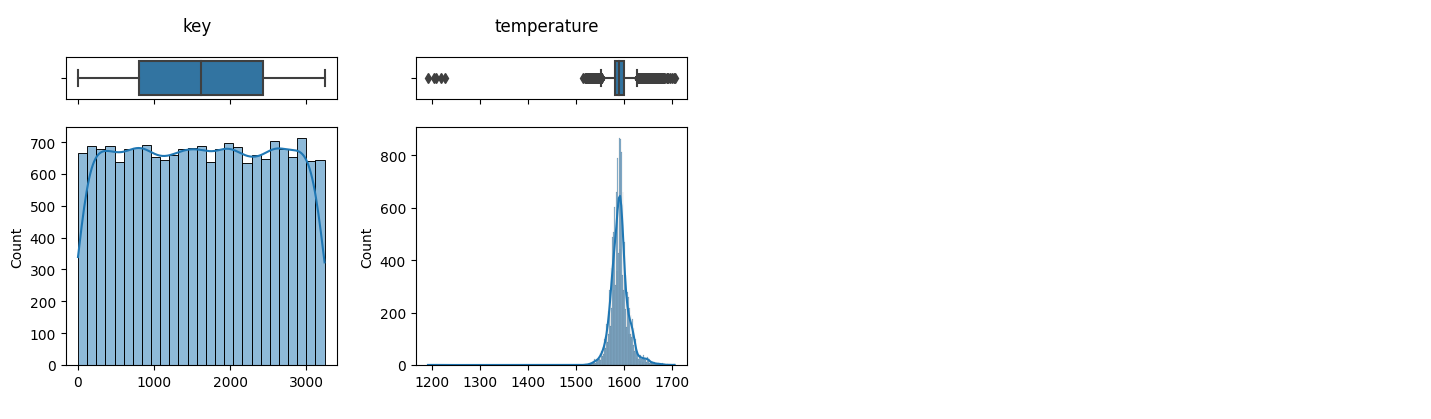

2. Исследовательский анализ данных

В ходе анализа данных выявлен ряд важных аномалий и паттернов, которые могут иметь значимое влияние на производственный процесс:

Обнаружены низкие значения температур плавления стали, такие как 1191°C, что не характерно для типичных процессов обработки стали. 


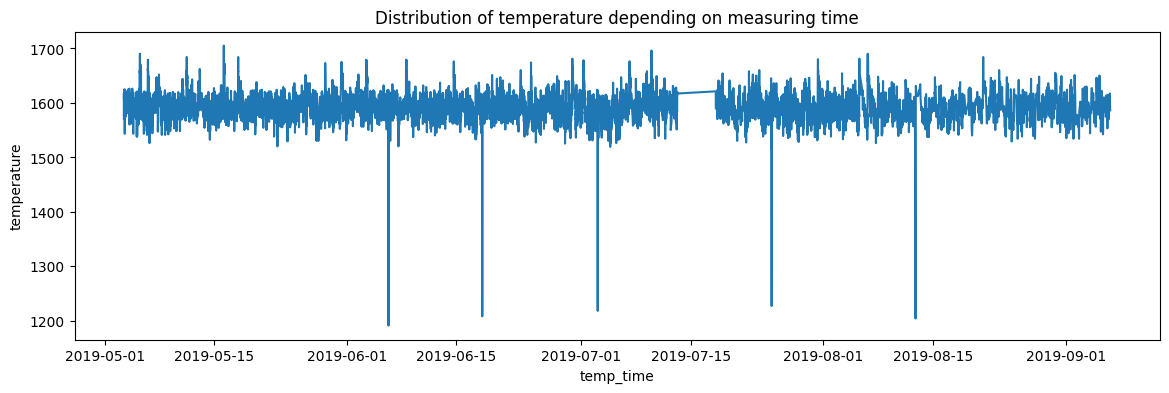

Предполагается, что данная температура может соответствовать сталям с особыми характеристиками, таким как ледебуритные (карбидные) стали типа быстрорежущие стали или стали для инструментов холодной штамповки, что можно увидеть на диаграмме железо-углерод, прсдавтленной ниже. Но данные стали редкоиспользуемые и не соответствуют большинству предоставленных данных. Поэтому данные аномалии удалены из-за низкой описательной достоверности для стандартного прозводственного процесса

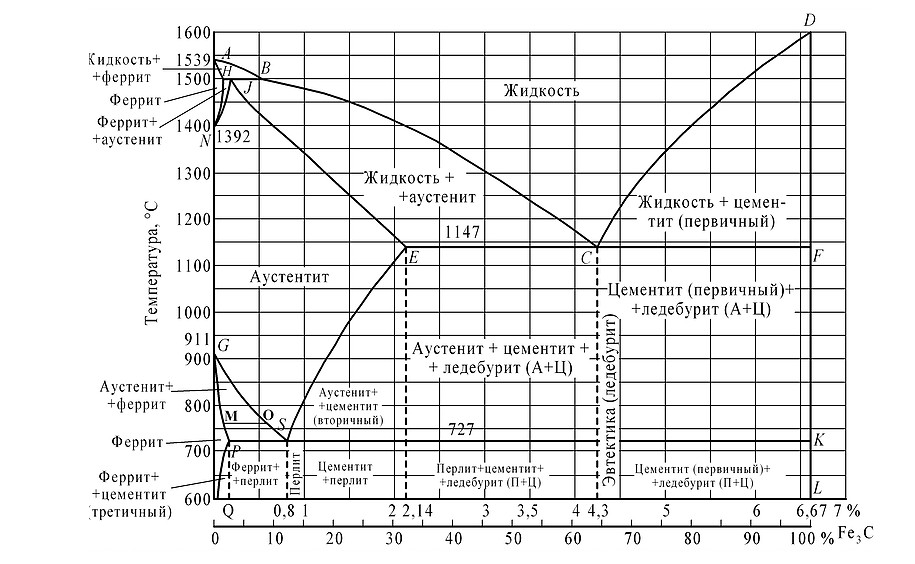

График температур в зависимости от партии показывает неравномерность и разброс значений. Это может свидетельствовать о неконсистентности параметров нагрева в производственном процессе. Следует провести анализ и определить причины этой нестабильности, чтобы обеспечить более однородное производство. На основе этого графика была произведена оценка партии старше 2500 и определено ниличие в них единичных измерений температур на начальном этапе

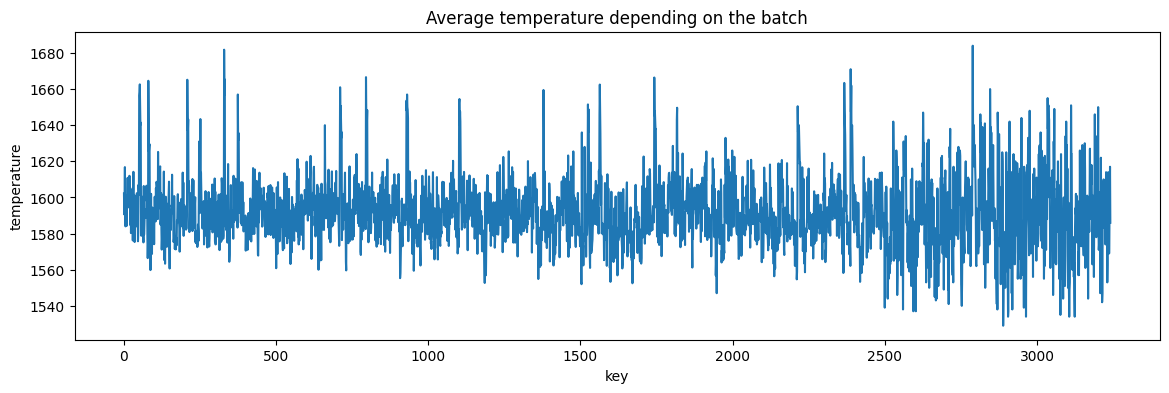

Оценка партий с единичными замерами температур позволила избавиться от нескольких сотен строк, которые непременно внесли бы шумы в модель предсказаний
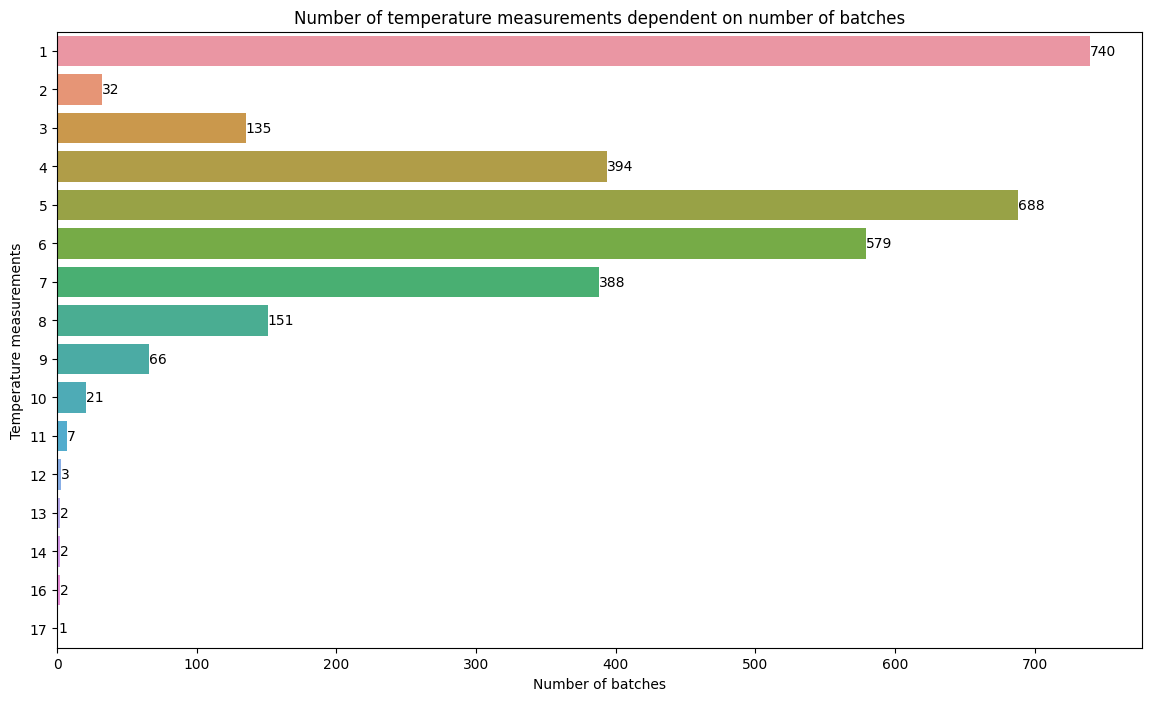

Обнаружены выбросы в данных о реактивной мощности, что может указывать на возможные скачки напряжения, неисправности оборудования или необходимость компенсации реактивной мощности. Такие аномалии так же были исключены из анализа

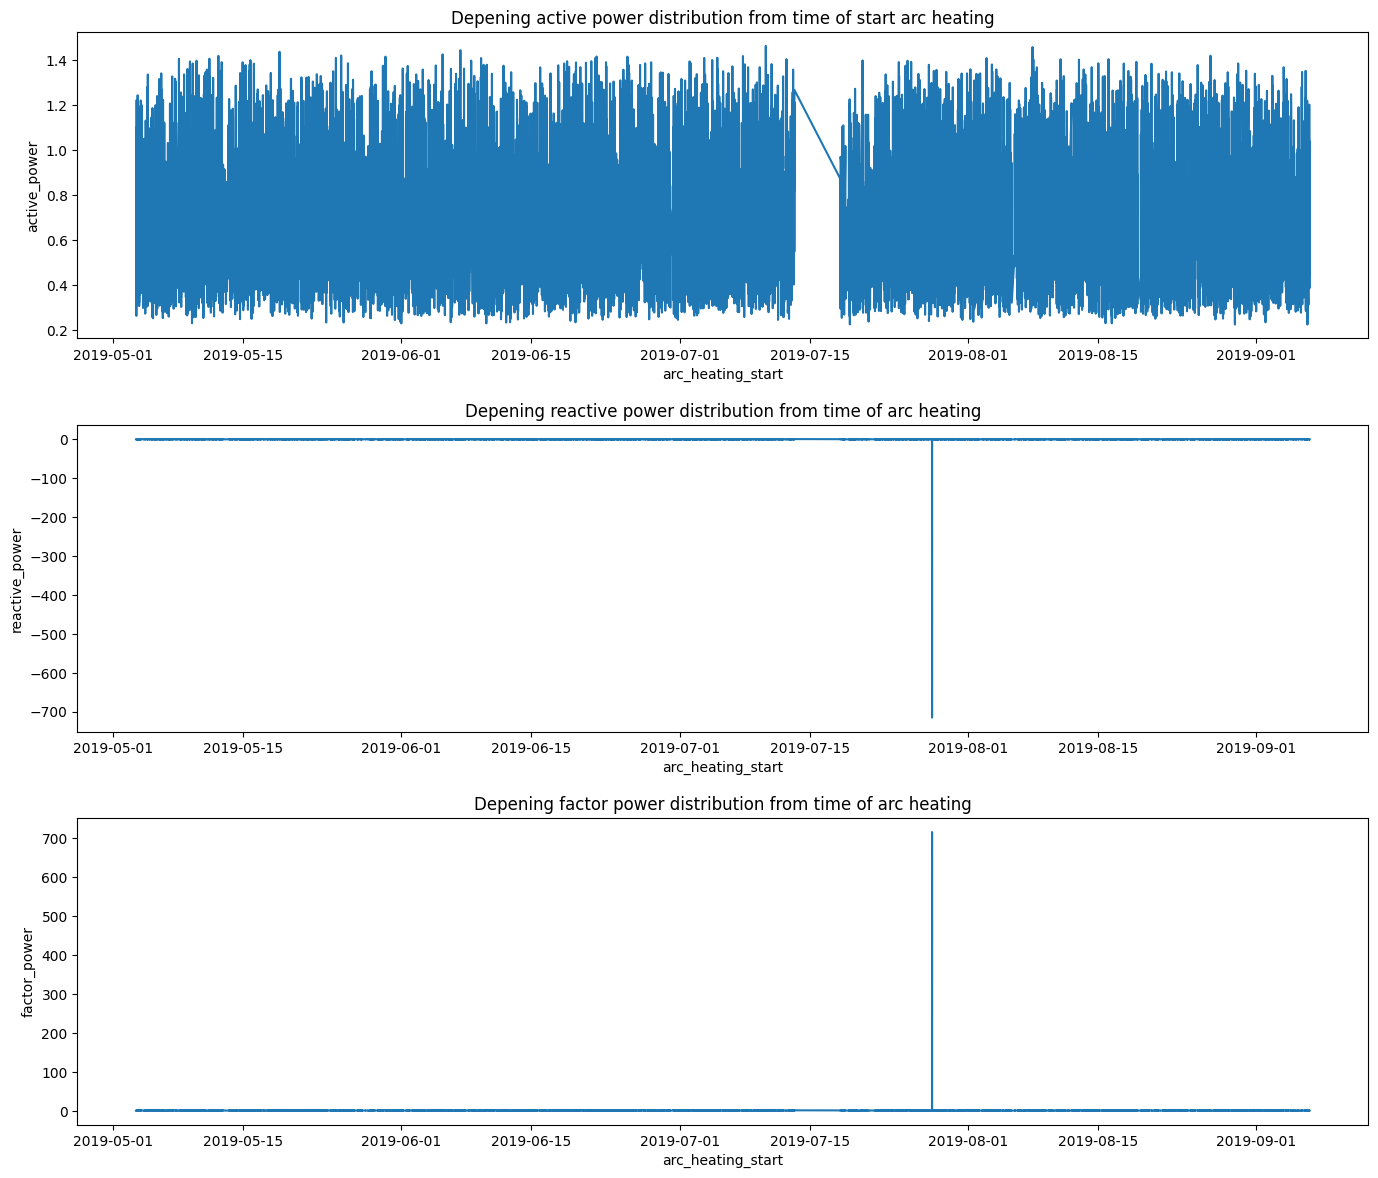


Выявлены аномально высокие максимальные значения объема газа для продувки стали для одних и тех же температур, что может быть связано с изменениями в производственных процессах или оборудовании. Рекомендуется проанализировать источники этих аномалий и оптимизировать объемы газа для обеспечения эффективной продувки.

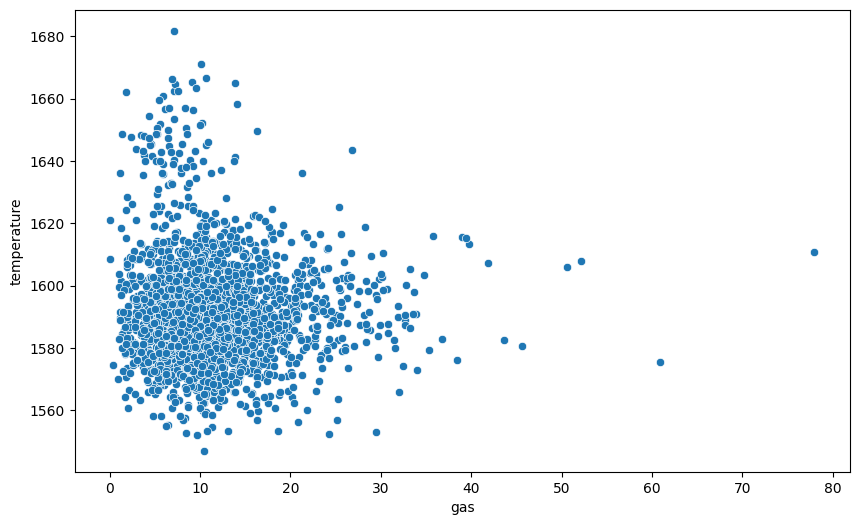

Обнаружено недостаточное количество данных о подаче сыпучих и проволочных материалов, что может повлиять на качество и производительность процесса обработки стали. Рекомендуется оптимизировать подачу материалов или искать альтернативные решения для обеспечения устойчивости производства.


В целом, для обеспечения стабильности, эффективности и качества производственного процесса, рекомендуется провести комплексный анализ и внести коррективы в технологические процессы, оборудование и контрольные мероприятия. Это позволит достичь более высокой энергоэффективности, повысить качество продукции и минимизировать риски аварий и потерь.

__3. Обучение и выбор нескольких base-line моделей__

На этом этапе были подготовлены исходные данные для обучения моделей. Созданы признаки на основе предоставленных данных для каждой партии: 
* длительность нагрева дугой, кчто влияет на качество и структуру стали;
* среднее значение фактора мощности для оценки электроэнерегитической эффективности процесса;
* первое и последнее измерения температуры, первое измерение - как отправная точка для замера температуры и последняя температура была определена целевым признаком, который предсказывается;
* данные о времени добавления сыпучих/проволочных материалов, что может быть полезным для определения типов и объемов материалов;
* данные о добавлении того или иного типа проволочных/сыпучих материалов, что дает информацию о температурных изменениях;
* объемы газа для продувки, влияющие на фактор мощности;
* общее время между первой и последней операцией каждой партии, влияющее на конечные свойства продукции.

Так же проведен анализ коррелирующих признаков и удалены те из них, корреляция которых превысила значение 0.9. Так же были удалены неиформативные, пустые признаки.

В качестве базовых моделей для оценки качества была выбрана модель линейной регрессии, как самая простая и интерпретирумая модель машинного обучения. Полученный метрики для данной модели: среднее абсолютное значение ошибки 6.26 и коэффициент детерминации 0.49

__4. Обучение и тестирование модели__

Для дальнейшего обучения были выбраны модели Ridge и Lasso регрессия, а так же CatBoostRegressor. Модели Ridge и Lasso регрессии включены, чтобы учесть мультиколлинеарность признаков и выполнить регуляризацию. CatBoostRegressor был выбран как более сложная модель, способная улавливать нелинейные зависимости между признаками и целевой переменной. Все модели обернуты в Pipeline с предварительной стандартизацией данных при помощи RobustScaler. Это важно для обеспечения стабильности моделей и учета различий в масштабах признаков. При обучении моделей была использована кросс-валидация, которая позволяет более надежно оценить производительность модели на новых данных, минимизируя эффект вариативности выборки. Это особенно важно для обеспечения надежной оценки моделей в реальных условиях. Проведенная оптимизация по двум метрикам, таким как среднее абсолютное значение ошибки (mean absolute error) и коэффициент детерминации R^2 (r2), позволяет учесть разные аспекты производительности модели. Процесс обучения представлен на графике ниже
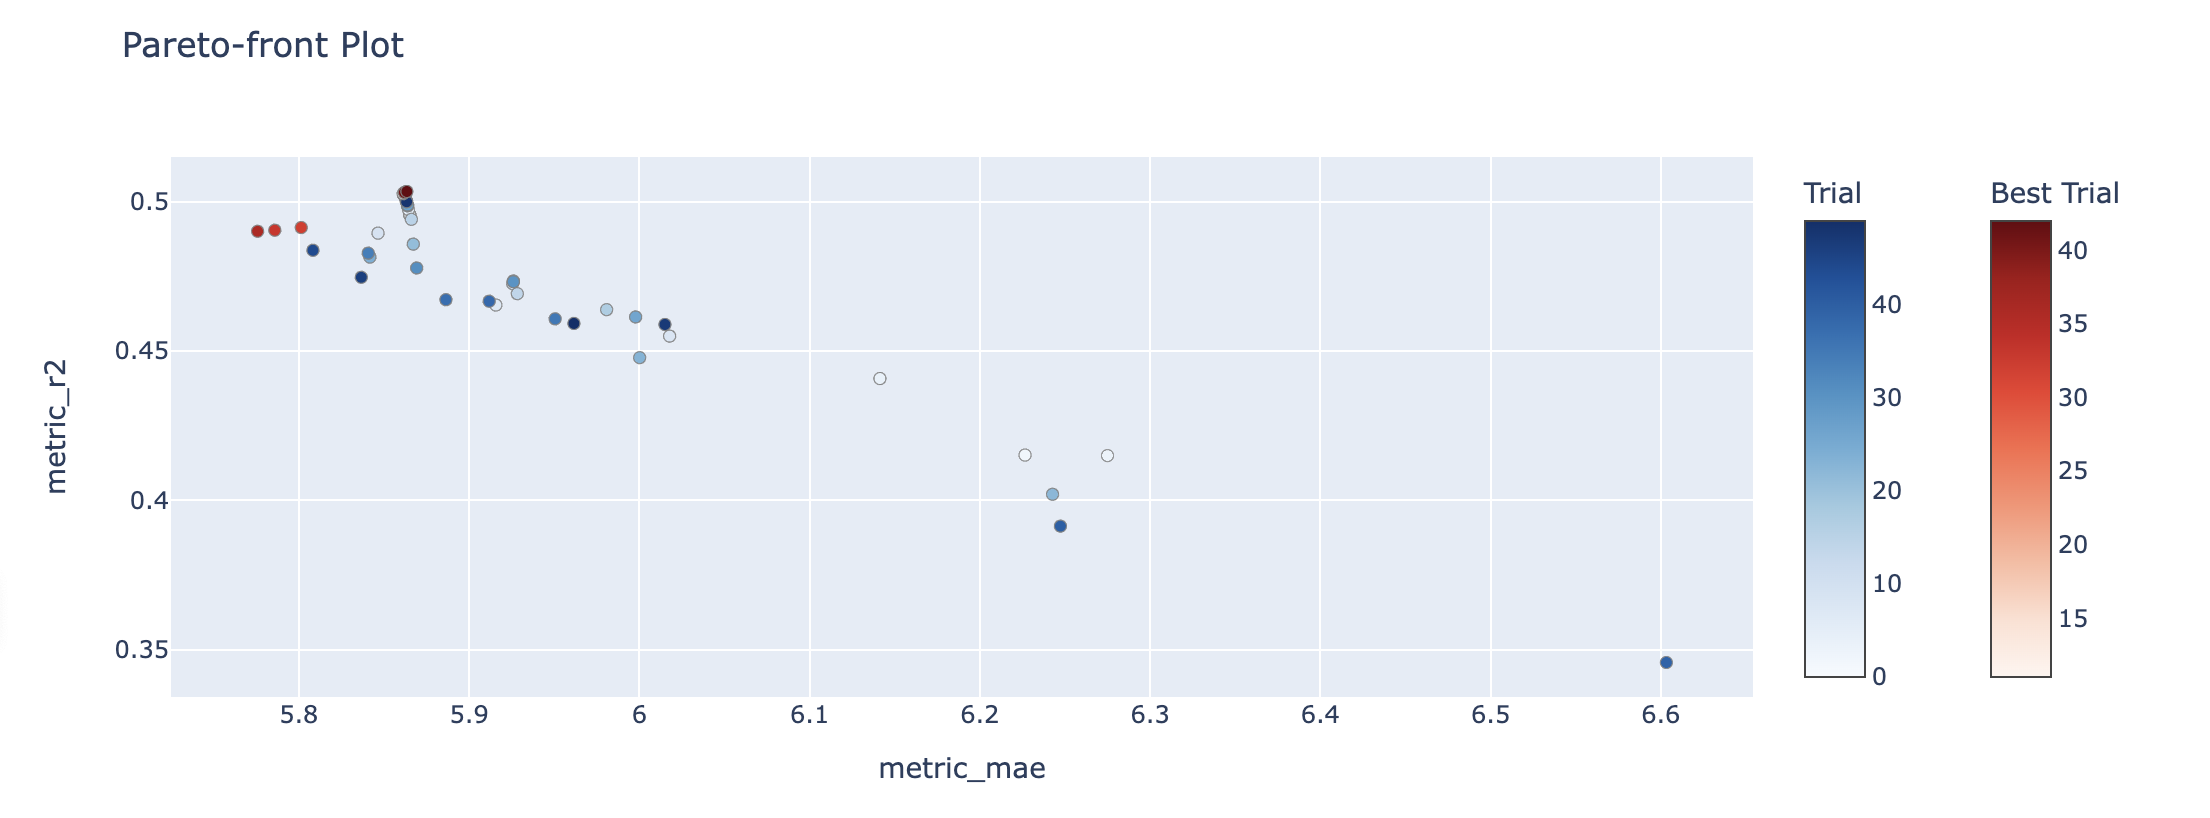


Наилучшей моделью оказалась Ridge регрессия с показателями MAE 5.86 и $R^2$ 0.5 на обучающих данных. Анализ важности признаков с помощью библиотеки SHAP перестановочным методом помог оценить влияние каждого признака на целевую, то есть, на предсказываемую темепературу. Наибольшее влияние на конечную температуру оказывает длительность нагрева в секундах(arc_heating_end), первичное измерение температуры(first), а также объемы и наличие конкретных проволочных и сыпучих материалов. Кроме того, важную роль играет общее время операций для каждой партии.

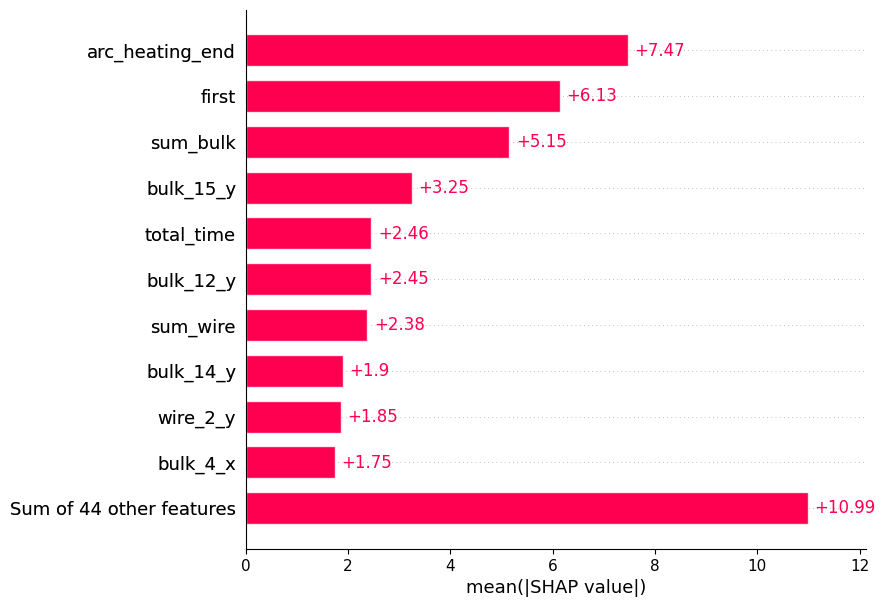

Финальные метрики на показали хорошие результаты в сравнении с базовой моделью MAE 6.24 градусов, а коэффициент детерминации $R^2$ 0.5, что свидетельствует о хорошей адаптации модели к данным


5. Заключение

Мы провели анализ данных и применили моделирование для оптимизации производства стали. Результаты позволили сделать следующие выводы:

* Обнаружены аномальные температурные значения, требуется дополнительное исследование.
* Эффективность энергопотребления нуждается в оптимизации.
* Материалы используются неэффективно, требуется настройка подачи.
* Процесс нагрева требует стабилизации.
* Газовая продувка требует анализа и оптимизации объемов.
* Созданная модель регрессии позволяет предсказывать температуру с низкой ошибкой и высокой точностью. Это поможет улучшить качество продукции и сократить расходы на энергию. Модель также способствует оптимизации материалов и процессов.

Рекомендации для производства:

* Провести исследование аномалий температуры.
* Оптимизировать энергопотребление на основе анализа мощности.
* Улучшить стабильность процесса нагрева.
* Оптимизировать использование материалов.
* Внедрить мониторинг параметров для контроля и предотвращения аномалий.

Эти рекомендации помогут повысить качество и эффективность производства. Созданная модель регрессии предоставляет точные данные для более надежного анализа и оптимизации процессов. В целом, анализ данных и моделирование имеют большой потенциал для оптимизации производства и повышения конкурентоспособности.




6. Отчет

Рекомендации:

Рекомендуется внедрение выбранной модели в производственный процесс для прогнозирования конечной температуры плавки. Для дальнейшего улучшения модели можно рассмотреть добавление дополнительных признаков и провести более детальный анализ важности признаков. Также, стоит обратить внимание на возможность периодического обновления модели с учетом новых данных.

Сложности и их решения:

В процессе работы над проектом столкнулась со сложностями в достижении требуемого качества модели. Однако благодаря систематическому подходу и использованию эффективных методов, удалось успешно преодолеть эти трудности.

Проблемы с недостаточным качеством модели решались путем анализа набора признаков. Идентификация наиболее информативных признаков позволила существенно улучшить производительность модели и уменьшить риск переобучения.

Однако ключевым шагом стало использование библиотеки Optuna для подбора гиперпараметров. Этот инструмент автоматизировал и упростил процесс оптимизации, позволив провести систематический поиск по пространству гиперпараметров. В результате были выявлены оптимальные параметры для моделей, обеспечивая максимальное качество предсказаний на выбранных метриках.

В итоге, использование анализа признаков и метода подбора гиперпараметров с использованием Optuna сыграло решающую роль в преодолении сложностей с качеством модели. Полученные результаты стали более точными и надежными, что позволило достичь требуемого уровня производительности и более уверенно применять модель в реальных задачах.

Сравнив результаты решения с планом, можно сказать, что все этапы выполнены успешно. Все запланированные шаги проекта были реализованы в полном объеме. 